In [1]:
import math
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import os

%matplotlib inline
plt.rcParams.update({
        'font.size': 14,
        'axes.titlesize': 20,
        'axes.labelsize': 20,
        'xtick.labelsize': 20,
        'ytick.labelsize': 20,
        'font.size': 20,
        'figure.figsize': (10, 7),
        'axes.grid': True,
        'grid.linestyle': '-',
        'grid.alpha': 0.3,
        'lines.markersize': 5.0,
        'xtick.minor.visible': True,
        'xtick.direction': 'in',
        'xtick.major.size': 20.0,
        'xtick.minor.size': 10.0,
        'xtick.top': False,
        'xtick.bottom': True,
        'ytick.minor.visible': True,
        'ytick.direction': 'in',
        'ytick.major.size': 12.0,
        'ytick.minor.size': 6.0,
        'ytick.right': True,
        'errorbar.capsize': 0.0,
    })


In [2]:
def mann_whitney(column):
    x1 = data.loc[data['Revenue'] == 0, column]
    x2 = data.loc[data['Revenue'] != 0, column]
    stat, p_value = stats.mannwhitneyu(x1, x2)
    return stat, p_value

In [3]:
# pd.cut() can do the same

def custom_binning(col, bin_edges, include_zero):
    bin_values = [
        data[(data[col] > bin_edges[i])
             & (data[col] <= bin_edges[i + 1])].shape[0]
        for i in range(len(bin_edges) - 1)
    ]
    bin_values_pos = [
        data[(data[col] > bin_edges[i])
             & (data[col] <= bin_edges[i + 1])
             & (data['Revenue'] > 0)].shape[0]
        for i in range(len(bin_edges) - 1)
    ]

    if (include_zero):
        bin_values = [data[data[col] == 0].shape[0]] + bin_values
        bin_values_pos = [
            data[(data[col] == 0)
                 & (data['Revenue'] > 0)].shape[0]
        ] + bin_values_pos

    return (np.array(bin_values_pos) / np.array(bin_values))

In [4]:
def bin_errors(col, bin_edges, include_zero):
    bin_values = [
        data[(data[col] > bin_edges[i])
             & (data[col] <= bin_edges[i + 1])].shape[0]
        for i in range(len(bin_edges) - 1)
    ]
    bin_values_pos = [
        data[(data[col] > bin_edges[i])
             & (data[col] <= bin_edges[i + 1])
             & (data['Revenue'] > 0)].shape[0]
        for i in range(len(bin_edges) - 1)
    ]

    if (include_zero):
        bin_values = [data[data[col] == 0].shape[0]] + bin_values
        bin_values_pos = [
            data[(data[col] == 0)
                 & (data['Revenue'] > 0)].shape[0]
        ] + bin_values_pos
    
    sigma_tot = np.sqrt(bin_values)
    sigma_pos = np.sqrt(bin_values_pos)
    corr = np.corrcoef(bin_values, bin_values_pos)[0, 1]
    # derivation by positive value in bins
    df_dv_pos = 1 / np.array(bin_values)
    df_dv_tot = -np.array(bin_values_pos) / np.square(np.array(bin_values))
    
    errors = np.sqrt(np.square(df_dv_pos * sigma_pos) + np.square(df_dv_tot * sigma_tot)\
        + (corr * sigma_pos * sigma_tot * df_dv_tot * df_dv_pos)) 
        
    return errors

# Dataset description

Online Shoppers Purchasing Intention Dataset

The Revenue attribute can be used as the class label.

Administrative, Administrative Duration, Informational, Informational Duration, Product Related and Product Related Duration represent the number of different types of pages visited by the visitor in that session and total time spent in each of these page categories. The values of these features are derived from the URL information of the pages visited by the user and updated in real time when a user takes an action, e.g. moving from one page to another.

The Bounce Rate, Exit Rate and Page Value features represent the metrics measured by "Google Analytics" for each page in the e-commerce site. The value of Bounce Rate feature for a web page refers to the percentage of visitors who enter the site from that page and then leave ("bounce") without triggering any other requests to the analytics server during that session. The value of "Exit Rate" feature for a specific web page is calculated as for all pageviews to the page, the percentage that were the last in the session. The Page Value feature represents the average value for a web page that a user visited before completing an e-commerce transaction.

The Special Day feature indicates the closeness of the site visiting time to a specific special day (e.g. Mother’s Day, Valentine's Day) in which the sessions are more likely to be finalized with transaction. The value of this attribute is determined by considering the dynamics of e-commerce such as the duration between the order date and delivery date. For example, for Valentina’s day, this value takes a nonzero value between February 2 and February 12, zero before and after this date unless it is close to another special day, and its maximum value of 1 on February 8.

The dataset also includes operating system, browser, region, traffic type, visitor type as returning or new visitor, a Boolean value indicating whether the date of the visit is weekend, and month of the year.

Link to the description of the original dataset
https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset

# 1. Load data

In [5]:
data = pd.read_csv('online_shoppers_intention.csv')
data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [6]:
print(f'Data consists of {data.shape[1]} columns and {data.shape[0]} rows')

Data consists of 18 columns and 12330 rows


## 1.1 First look at data

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12131 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  11839 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12231 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [8]:
data.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12131.000000,12330.000000,11839.000000,12330.000000,12231.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.724502,31.731468,1190.534914,0.022191,0.043021,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,141.655684,44.475503,1908.447706,0.048488,0.048562,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,183.854167,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,597.625000,0.003112,0.025141,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1462.554562,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


In [9]:
data.describe(include='object')

,Month,VisitorType
count,12330,12330
unique,11,3
top,May,Returning_Visitor
freq,3348,10551


In [10]:
initial_data_types = data.dtypes.value_counts()
for i in initial_data_types.index:
    print(f'{data.dtypes[data.dtypes == i].shape[0]} {i} columns')

7 float64 columns
7 int64 columns
2 bool columns
2 object columns


<font size="3">
Target column 'Revenue' has type bool. Transform it to integer right away <br>
Also transform 'Weekend' column
<font>

In [11]:
data['Revenue'] = data['Revenue'].astype(np.int8)
data['Weekend'] = data['Weekend'].astype(np.int8)

In [12]:
data['Revenue'].value_counts()

0    10422
1     1908
Name: Revenue, dtype: int64

<font size="4">
<b> Data is unbalanced </b>
<font>

## 1.2 Handle missed values

In [13]:
data.isnull().sum()

Administrative               0
Administrative_Duration      0
Informational                0
Informational_Duration     199
ProductRelated               0
ProductRelated_Duration    491
BounceRates                  0
ExitRates                   99
PageValues                   0
SpecialDay                   0
Month                        0
OperatingSystems             0
Browser                      0
Region                       0
TrafficType                  0
VisitorType                  0
Weekend                      0
Revenue                      0
dtype: int64

In [14]:
for col in data.columns[data.isnull().sum() > 0]:
    print(col, 'missing values')
    print(f"{round((data[col].isnull().sum() / data.shape[0]) * 100, 3)} %")

Informational_Duration missing values
1.614 %
ProductRelated_Duration missing values
3.982 %
ExitRates missing values
0.803 %


In [15]:
data.dtypes[data.isnull().sum() > 0]

Informational_Duration     float64
ProductRelated_Duration    float64
ExitRates                  float64
dtype: object

<font size="3">

Data has 3 columns with missing values with type 'float'. <br>
Simple solutions for this type of data is to:
* replace NaNs with mean value of column
* replace NaNs with median value (if distribution has heavy tail)
    
<font>

--------------------------------------------------
Informational_Duration
median   = 0.0
mean     = 34.72450155416108
skewness = 7.543068097422117
--------------------------------------------------
ProductRelated_Duration
median   = 597.625
mean     = 1190.534914064685
skewness = 7.393584199422583
--------------------------------------------------
ExitRates
median   = 0.025141026
mean     = 0.04302104039784155
skewness = 2.1536554821516662
--------------------------------------------------


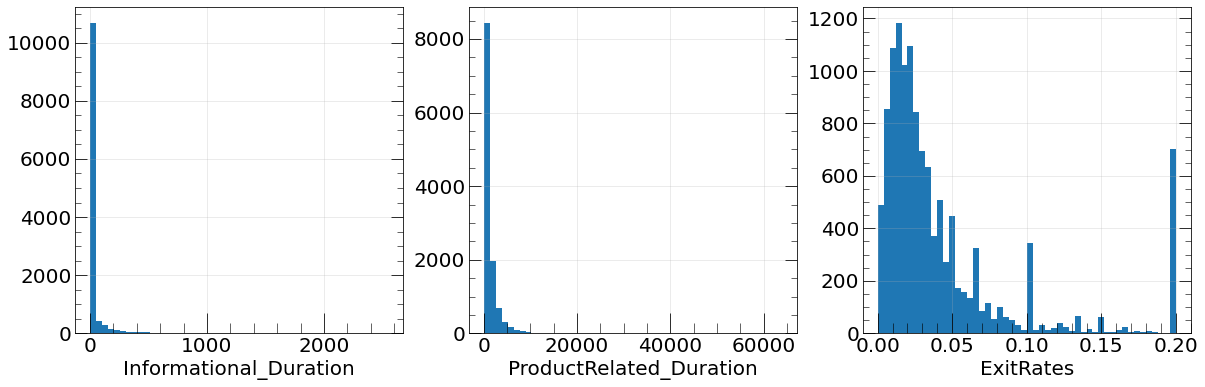

In [16]:
print('-'*50)
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
for i, col in enumerate(data.columns[data.isnull().sum() > 0]):
    print(col)
    print(f"median   = {data[col].median()}")
    print(f"mean     = {data[col].mean()}")
    print(f"skewness = {stats.skew(data[col].dropna())}")
    print('-'*50)
    ax[i].hist(data[col], bins=50)
    ax[i].set_xlabel(col)

<font size="3">

<b>Inference:</b>
    
Distributions of all three features have very long right tails (i.e. skewness >> 0). <br>
Better to replace missing values with medians
    
<font>

In [17]:
for col in data.columns[data.isna().sum() > 0]:
    data[col].fillna(data[col].median(), inplace=True)

# Outliers

# 2. EDA

In [18]:
import scipy.stats as stats

In [19]:
num_cols = data.columns[data.dtypes != object]
num_cols

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Weekend',
       'Revenue'],
      dtype='object')

## 2.1. Numeric columns

### 2.1.1. Administrative

Administrative -> int64
Mann-Whitney p-value = 6.559658546264956e-78


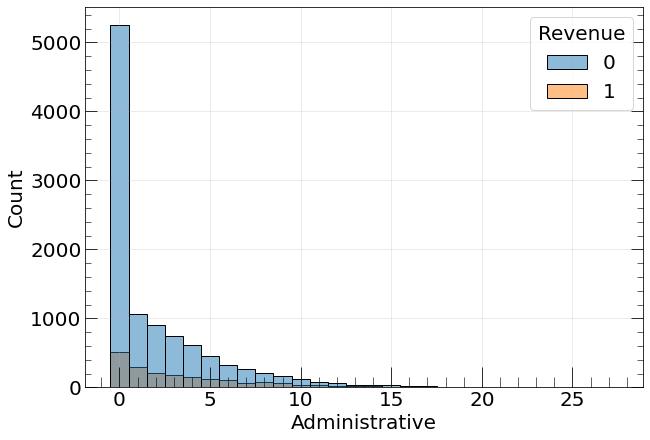

In [20]:
print('Administrative ->', data['Administrative'].dtype)
print(f"Mann-Whitney p-value = {mann_whitney('Administrative')[1]}")
sns.histplot(data=data,
             x='Administrative',
             hue="Revenue",
             multiple="layer",
             discrete=True)
plt.show()

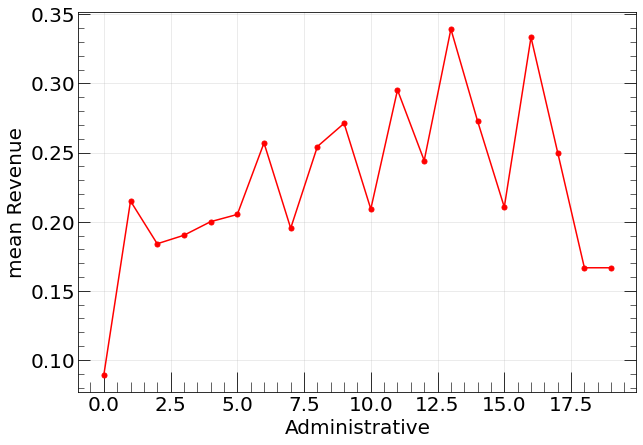

In [21]:
def plot_mean_revenue(col, range_high, range_low):
    points = data.loc[(data[col] < range_high) & (data[col] > range_low)]\
        .groupby(col).agg(MeanRevenue=('Revenue', 'mean'))
    plt.plot(points, 'o-r')
    plt.xlabel(col)
    plt.ylabel('mean Revenue')
    plt.show()
    

plot_mean_revenue('Administrative', 20, -1)

In [22]:
print('Mean revenue among objects with Administrative_duration = 0:',
      round(data.loc[data['Administrative'] == 0, ['Revenue']].mean().values[0], 4),
      sep='\n')
print('Mean revenue among objects with Administrative_duration != 0:',
      round(data.loc[data['Administrative'] != 0, ['Revenue']].mean().values[0], 4),
      sep='\n')

Mean revenue among objects with Administrative_duration = 0:
0.0891
Mean revenue among objects with Administrative_duration != 0:
0.2124


### Administrative_Duration

Administrative_Duration -> float64
Mann-Whitney p-value = 2.3361304523849337e-74


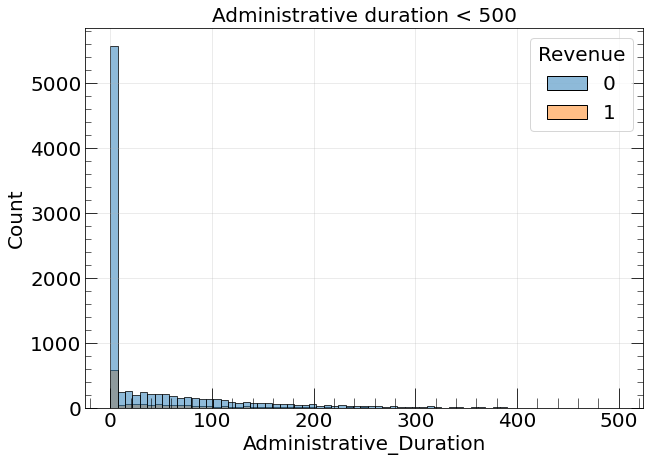

In [23]:
print('Administrative_Duration ->', data['Administrative_Duration'].dtype)
print(f"Mann-Whitney p-value = {mann_whitney('Administrative_Duration')[1]}")
sns.histplot(data=data[data['Administrative_Duration'] < 500],
             x='Administrative_Duration',
             hue="Revenue",
             multiple="layer")
plt.title('Administrative duration < 500')
plt.show()

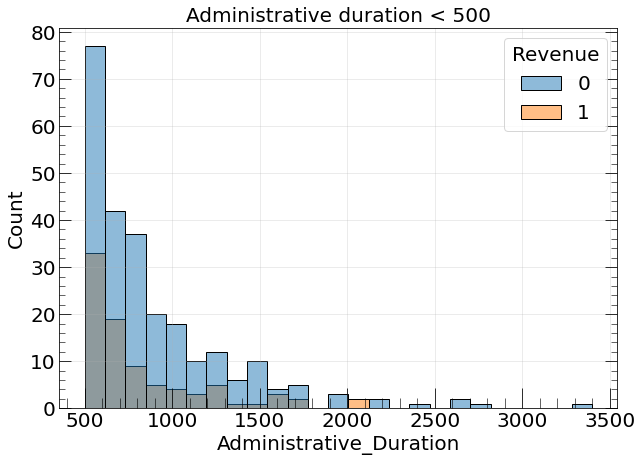

In [24]:
plt.title('Administrative duration < 500')
sns.histplot(data=data[data['Administrative_Duration'] >= 500],
             x='Administrative_Duration',
             hue="Revenue",
             multiple="layer")
plt.show()

In [25]:
data[data['Administrative_Duration'] == 0].shape[0] / data.shape[0]

0.4787510137875101

In [26]:
print('Mean revenue among objects with Administrative_duration = 0:',
      round(data.loc[data['Administrative_Duration'] == 0, ['Revenue']].mean().values[0], 4),
      sep='\n')
print('Mean revenue among objects with Administrative_duration != 0:',
      round(data.loc[data['Administrative_Duration'] != 0, ['Revenue']].mean().values[0], 4),
      sep='\n')

Mean revenue among objects with Administrative_duration = 0:
0.0928
Mean revenue among objects with Administrative_duration != 0:
0.2116


<font size="3">

~48% of objects have Administrative_Duration = 0. We clearly see that revenue among them are lower. <br>
But is it a trend?
    
<font>

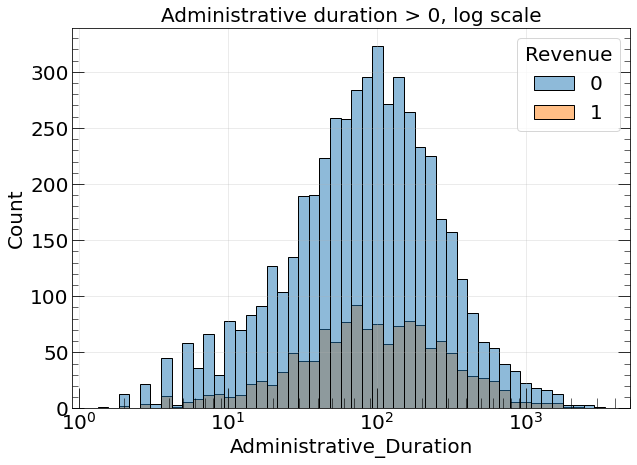

In [27]:
sns.histplot(data=data[data['Administrative_Duration'] > 0],
             x='Administrative_Duration',
             hue="Revenue",
             multiple="layer",
             log_scale=True)
plt.title('Administrative duration > 0, log scale')
plt.show()

In [28]:
bin_edges = [i*10 for i in range(10)] + [i*10 for i in range(10, 20, 2)] + \
    [i*10 for i in range(20, 30, 5)] + [i*10 for i in range(30, 50, 10)] + [500, 3500]
bin_centers = [(bin_edges[i]+bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]

In [29]:
bin_values = custom_binning('Administrative_Duration', bin_edges, include_zero=True)
bin_centers = [0] + bin_centers

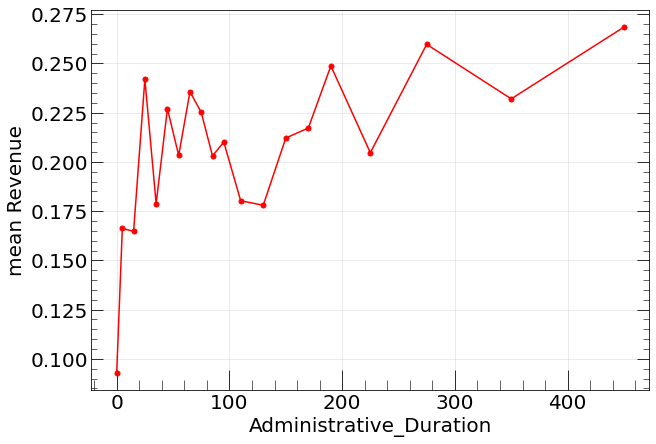

In [30]:
plt.plot(bin_centers[:-1], bin_values[:-1], 'o-r')
plt.xlabel('Administrative_Duration')
plt.ylabel('mean Revenue')
plt.show()

In [31]:
data[['Administrative', 'Administrative_Duration']].corr()

,Administrative,Administrative_Duration
Administrative,1.000000,0.601583
Administrative_Duration,0.601583,1.000000


<font size="3">

Inference: <br>
* There are significant difference in chances of 'Revenue' between users with 'Administrative' or 'Administrative_dureation' equals 0 and not equals 0. 
* It seems like there is mild linear trend (k is close to 0).
* May be we can transform these features to binary (0, 1)
* Two features are highly correlated (corr ~0.6)
    
<font>

### 2.1.2 Informational

Informational -> int64
Mann-Whitney p-value = 6.013906980370946e-37


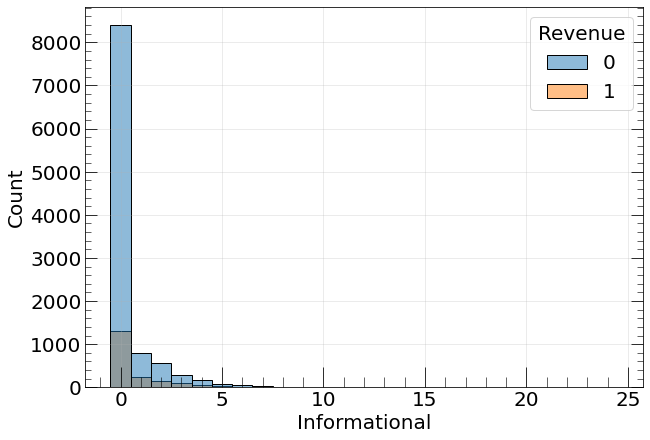

In [32]:
print('Informational ->', data['Informational'].dtype)
print(f"Mann-Whitney p-value = {mann_whitney('Informational')[1]}")
sns.histplot(data=data,
             x='Informational',
             hue="Revenue",
             multiple="layer",
             discrete=True)

plt.show()

In [33]:
data['Informational'].value_counts()

0     9699
1     1041
2      728
3      380
4      222
5       99
6       78
7       36
9       15
8       14
10       7
12       5
14       2
24       1
16       1
11       1
13       1
Name: Informational, dtype: int64

In [34]:
print('Mean revenue among objects with Informational = 0:',
      round(data.loc[data['Informational'] == 0, ['Revenue']].mean().values[0], 4),
      sep='\n')
print('Mean revenue among objects with Informational != 0:',
      round(data.loc[data['Informational'] != 0, ['Revenue']].mean().values[0], 4),
      sep='\n')

Mean revenue among objects with Informational = 0:
0.1335
Mean revenue among objects with Informational != 0:
0.233


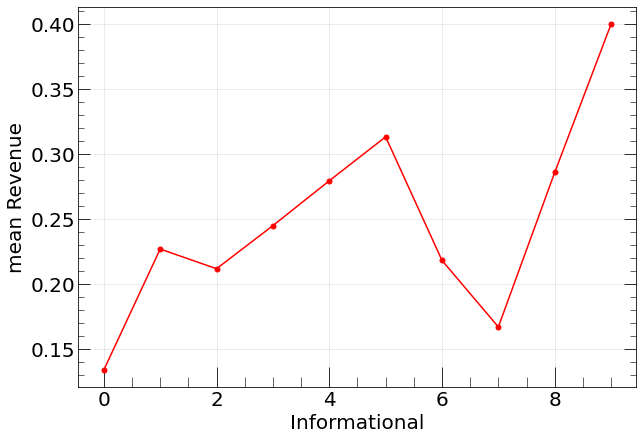

In [35]:
plot_mean_revenue('Informational', 10, -1)

### Informational Duration

Informational_Duration -> float64
Mann-Whitney p-value = 4.7750027212224915e-35


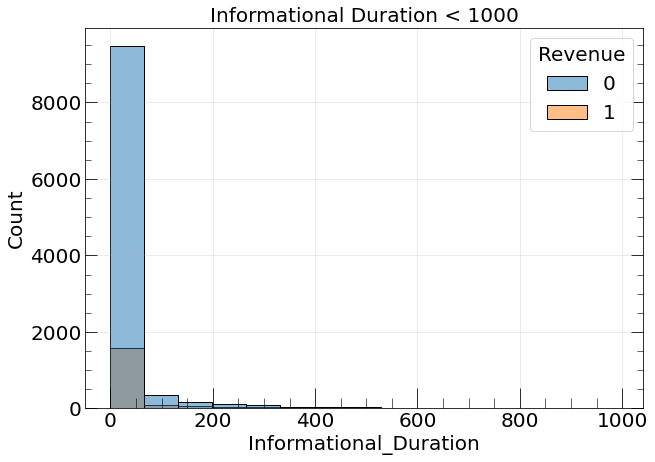

In [36]:
print('Informational_Duration ->', data['Informational_Duration'].dtype)
print(f"Mann-Whitney p-value = {mann_whitney('Informational_Duration')[1]}")
sns.histplot(data=data[data['Informational_Duration'] < 1000],
             x='Informational_Duration',
             hue="Revenue",
             multiple="layer")
plt.title('Informational Duration < 1000')
plt.show()

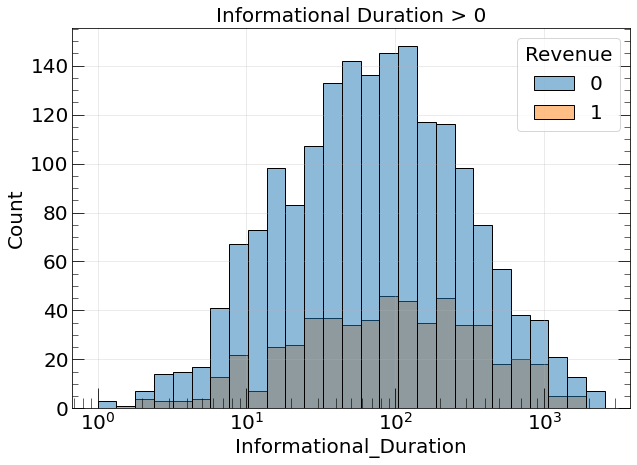

In [37]:
sns.histplot(data=data[(data['Informational_Duration'] > 0)],
             x='Informational_Duration',
             hue="Revenue",
             multiple="layer",
             log_scale=True)
plt.title('Informational Duration > 0')
plt.show()

In [38]:
bin_edges = [i*50 for i in range(10)] + [i*100 for i in range(5, 10)] + [1000, 3000]
bin_centers = [(bin_edges[i]+bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]
bin_centers = [0] + bin_centers

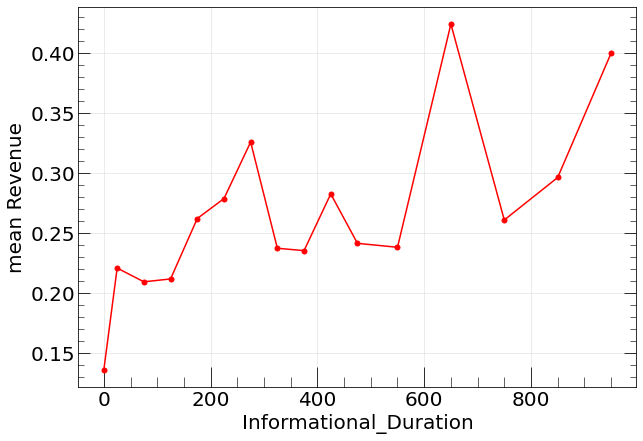

In [39]:
bin_values = custom_binning('Informational_Duration', bin_edges, include_zero=True)
plt.plot(bin_centers[:-1], bin_values[:-1], 'o-r')
plt.xlabel('Informational_Duration')
plt.ylabel('mean Revenue')
plt.show()

In [40]:
data[['Informational', 'Informational_Duration']].corr()

,Informational,Informational_Duration
Informational,1.000000,0.616051
Informational_Duration,0.616051,1.000000


<font size="3">

Inference (very similar to Administratve* features): <br>
* There are significant difference in chances of 'Revenue' between users with 'Informational' or 'Informational_dureation' equals 0 and not equals 0.
* May be we can transform these features to binary (0, 1)
* Two features are highly correlated (corr ~0.62)
    
<font>

### 2.1.3 Product Related

ProductRelated -> int64
Mann-Whitney p-value = 5.262192886345497e-108


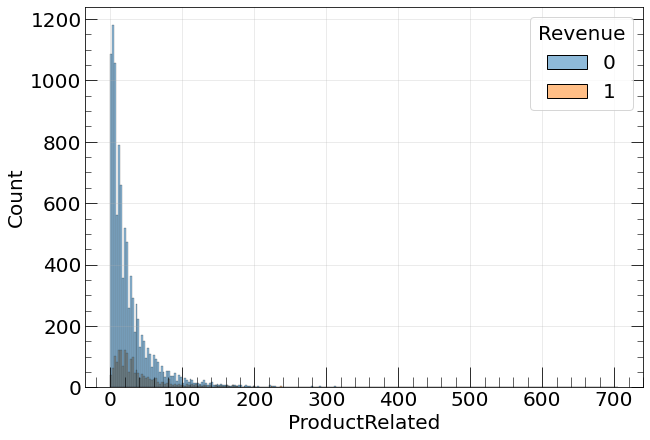

In [41]:
print('ProductRelated ->', data['ProductRelated'].dtype)
print(f"Mann-Whitney p-value = {mann_whitney('ProductRelated')[1]}")
sns.histplot(data=data,
             x='ProductRelated',
             hue="Revenue",
             multiple="layer")
plt.show()

In [42]:
print(f"Mean Revenue for objects with ProductRelated = 0: {data.loc[data['ProductRelated'] == 0, ['Revenue']].mean()[0]}")
print(f"Mean Revenue for objects with ProductRelated > 0: {data.loc[data['ProductRelated'] > 0, ['Revenue']].mean()[0]}")

Mean Revenue for objects with ProductRelated = 0: 0.15789473684210525
Mean Revenue for objects with ProductRelated > 0: 0.15473478685323788


Opposite to 'Adinistrative' and 'Informational' (also their durations) there is no significant difference between mean Revenue for zero vlaues and non-zero values

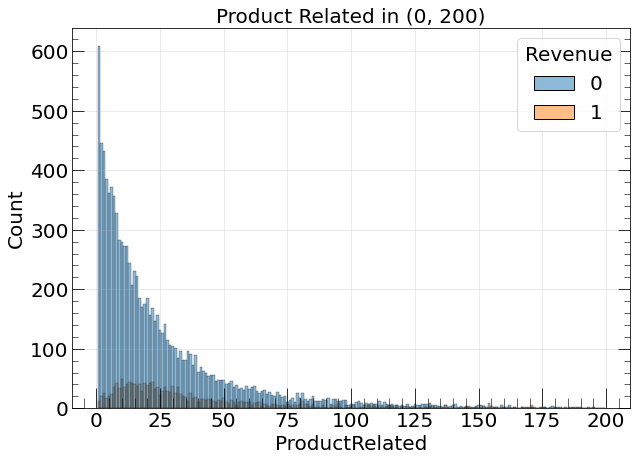

In [43]:
sns.histplot(data=data[(data['ProductRelated'] > 0) & (data['ProductRelated'] < 200)],
             x='ProductRelated',
             hue="Revenue",
             multiple="layer",
             discrete=True)
plt.title('Product Related in (0, 200)')
plt.show()

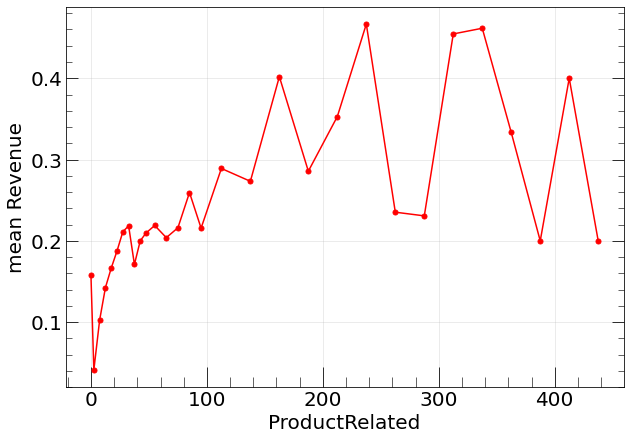

In [44]:
bin_edges = [i*5 for i in range(10)] + [i*10 for i in range(5, 11)] + [i*25 for i in range(5, 20)] + [700]
bin_centers = [(bin_edges[i]+bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]

bin_values = custom_binning("ProductRelated", bin_edges, include_zero=True)
bin_centers = [0] + bin_centers
plt.plot(bin_centers[:-2], bin_values[:-2], 'o-r')
plt.xlabel('ProductRelated')
plt.ylabel('mean Revenue')
plt.show()

In [45]:
from scipy.optimize import curve_fit

/home/andy/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


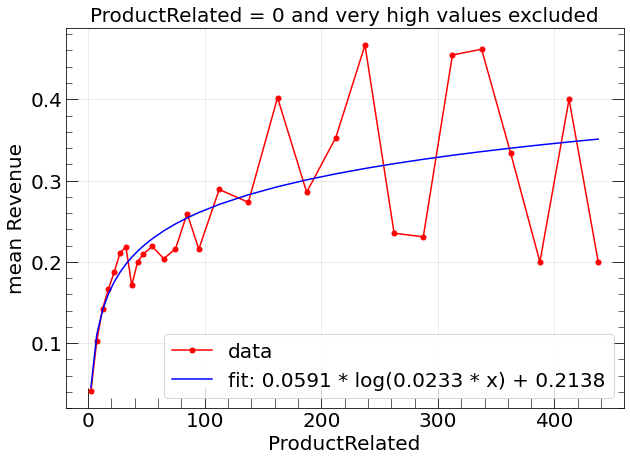

Log function: 0.0591 * log(0.0233 * x) + 0.2138


In [46]:
def log_func(x, a, b, c):
    return b * np.log(a * x) + c

x = np.array(bin_centers[1:-2])
y = np.array(bin_values[1:-2])
y_err = bin_errors("ProductRelated", bin_edges, include_zero=True)[1:-2]

popt = curve_fit(log_func, x, y)[0]
popt_round = list(map(lambda x: round(x, 4), popt))
popt_description = f'{popt_round[1]} * log({popt_round[0]} * x) + {popt_round[2]}'

plt.plot(x, y, 'o-r', label='data')
plt.plot(x, log_func(x, *popt), 'b-', label='fit: '+popt_description)
plt.xlabel('ProductRelated')
plt.ylabel('mean Revenue')
plt.title('ProductRelated = 0 and very high values excluded')
plt.legend()
plt.show()

print(f'Log function: {popt_round[1]} * log({popt_round[0]} * x) + {popt_round[2]}')

/home/andy/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


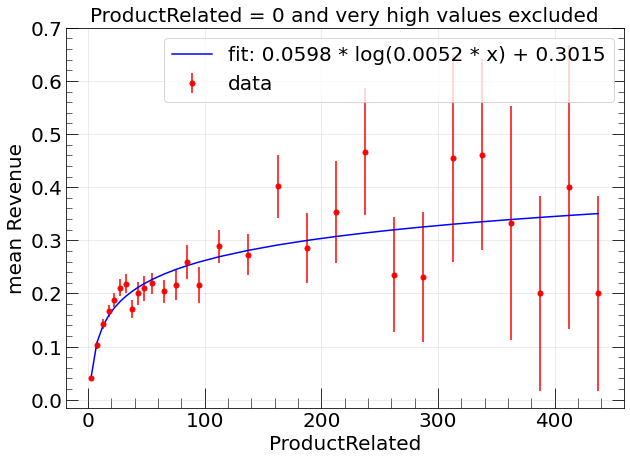

Log function: 0.0598 * log(0.0052 * x) + 0.3015


In [47]:
x = np.array(bin_centers[1:-2])
y = np.array(bin_values[1:-2])
y_err = bin_errors("ProductRelated", bin_edges, include_zero=True)[1:-2]

popt = curve_fit(log_func, x, y, sigma=y_err)[0]
popt_round = list(map(lambda x: round(x, 4), popt))
popt_description = f'{popt_round[1]} * log({popt_round[0]} * x) + {popt_round[2]}'

plt.errorbar(x, y, yerr=y_err, label='data', c='r', fmt='o')
plt.plot(x, log_func(x, *popt), 'b-', label='fit: '+popt_description)
plt.xlabel('ProductRelated')
plt.ylabel('mean Revenue')
plt.title('ProductRelated = 0 and very high values excluded')
plt.legend()
plt.show()

print(f'Log function: {popt_round[1]} * log({popt_round[0]} * x) + {popt_round[2]}')

### ProductRelated Duration

ProductRelated_Duration -> float64
Mann-Whitney p-value = 3.610801854133084e-120


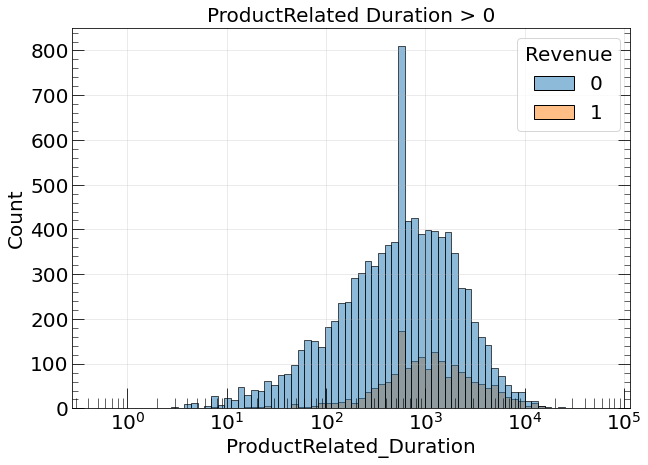

In [48]:
print('ProductRelated_Duration ->', data['ProductRelated_Duration'].dtype)
print(f"Mann-Whitney p-value = {mann_whitney('ProductRelated_Duration')[1]}")
sns.histplot(data=data[data['ProductRelated_Duration'] > 0],
             x='ProductRelated_Duration',
             hue="Revenue",
             multiple="layer",
             log_scale=True)
plt.title('ProductRelated Duration > 0')
plt.show()

In [49]:
print(
    f"Mean Revenue for objects with ProductRelated Duration = 0: {data.loc[data['ProductRelated_Duration'] == 0, ['Revenue']].mean()[0]}"
)
print(
    f"Mean Revenue for objects with ProductRelated Duration > 0: {data.loc[data['ProductRelated_Duration'] > 0, ['Revenue']].mean()[0]}"
)

Mean Revenue for objects with ProductRelated Duration = 0: 0.01662049861495845
Mean Revenue for objects with ProductRelated Duration > 0: 0.1633356305995865


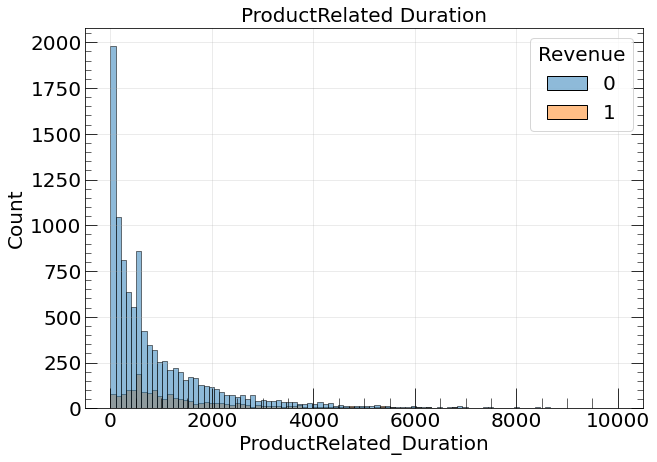

In [50]:
sns.histplot(data=data[data['ProductRelated_Duration'] < 10000],
             x='ProductRelated_Duration',
             hue="Revenue",
             multiple="layer")
plt.title('ProductRelated Duration')
plt.show()

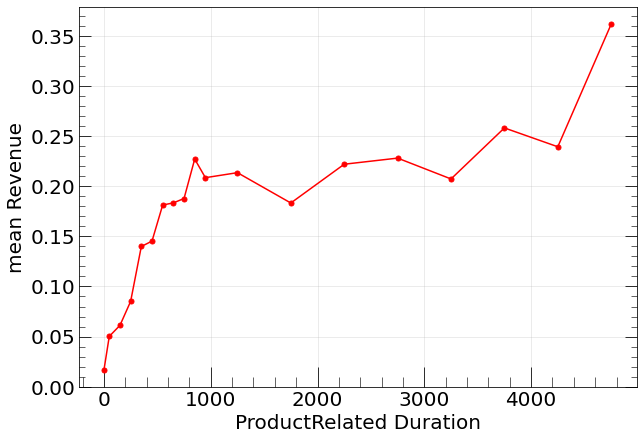

In [51]:
bin_edges = [i*100 for i in range(10)] + [i*500 for i in range(2, 13)]
bin_centers = [(bin_edges[i]+bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]

bin_values = custom_binning("ProductRelated_Duration", bin_edges, include_zero=True)
bin_centers = [0] + bin_centers
plt.plot(bin_centers[:-2], bin_values[:-2], 'o-r')
plt.xlabel('ProductRelated Duration')
plt.ylabel('mean Revenue')
plt.show()

/home/andy/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


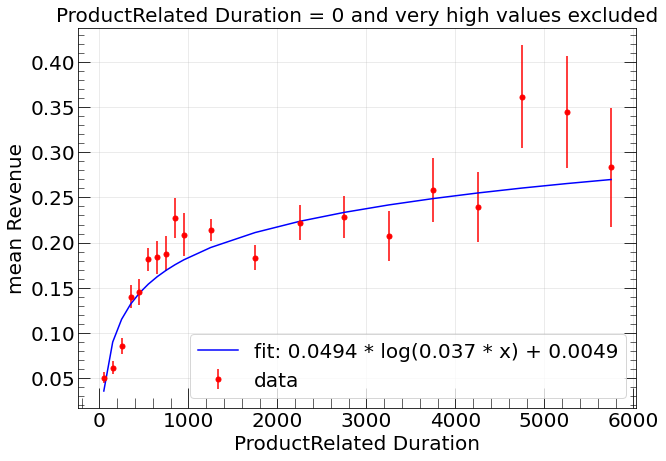

Log function: 0.0494 * log(0.037 * x) + 0.0049


In [52]:
x = np.array(bin_centers[1:])
y = np.array(bin_values[1:])
y_err = bin_errors("ProductRelated_Duration", bin_edges, include_zero=False)

popt = curve_fit(log_func, x, y, sigma=y_err)[0]
popt_round = list(map(lambda x: round(x, 4), popt))
popt_description = f'{popt_round[1]} * log({popt_round[0]} * x) + {popt_round[2]}'

plt.errorbar(x, y, yerr=y_err, label='data', c='r', fmt='o')
plt.plot(x, log_func(x, *popt), 'b-', label='fit: '+popt_description)
plt.xlabel('ProductRelated Duration')
plt.ylabel('mean Revenue')
plt.title('ProductRelated Duration = 0 and very high values excluded')
plt.legend()
plt.show()

print(f'Log function: {popt_round[1]} * log({popt_round[0]} * x) + {popt_round[2]}')

In [53]:
data[['ProductRelated', 'ProductRelated_Duration']].corr()

,ProductRelated,ProductRelated_Duration
ProductRelated,1.000000,0.837086
ProductRelated_Duration,0.837086,1.000000


<font size="3">

Inerence:
* Chance of Revenue grows as log with 'ProductRelated' and 'ProductRelated_Duration'
* Two features are highly correlated (~0.84)
* For 'ProductRelated' = 0 mean Revenue is equal to mean Revenue in 'ProductRelated' > 0
    
<font>

<AxesSubplot:>

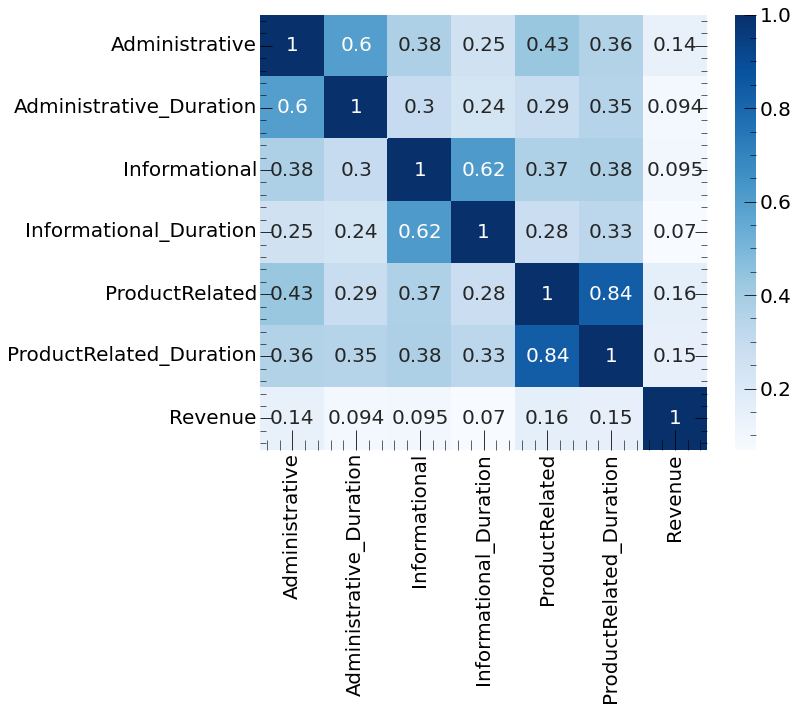

In [54]:
corr = data[[
    "Administrative", "Administrative_Duration", "Informational",
    "Informational_Duration", "ProductRelated", "ProductRelated_Duration",
    "Revenue"
]].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="Blues", annot=True)

### 2.1.4 BounceRates
The value of "Bounce Rate" feature for a web page refers to the percentage of visitors who enter the site from that page and then leave ("bounce") without triggering any other requests to the analytics server during that session.

BounceRates -> float64
Mann-Whitney p-value = 9.163850295589794e-62


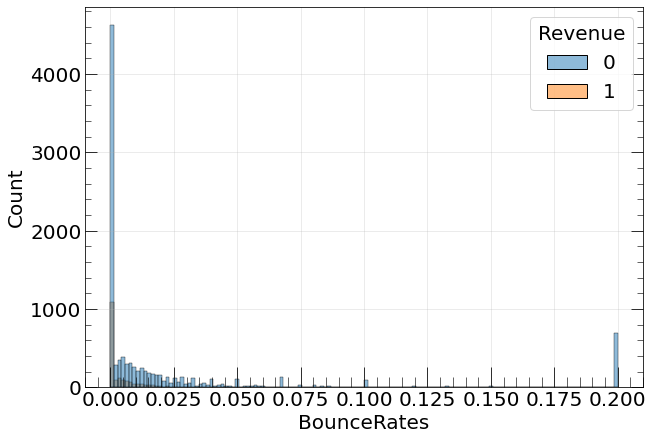

In [55]:
print('BounceRates ->', data['BounceRates'].dtype)
print(f"Mann-Whitney p-value = {mann_whitney('BounceRates')[1]}")
sns.histplot(data,
             x='BounceRates',
             hue="Revenue",
             multiple="layer",
             #log_scale=True
            )
#plt.title('ProductRelated Duration > 0')
plt.show()

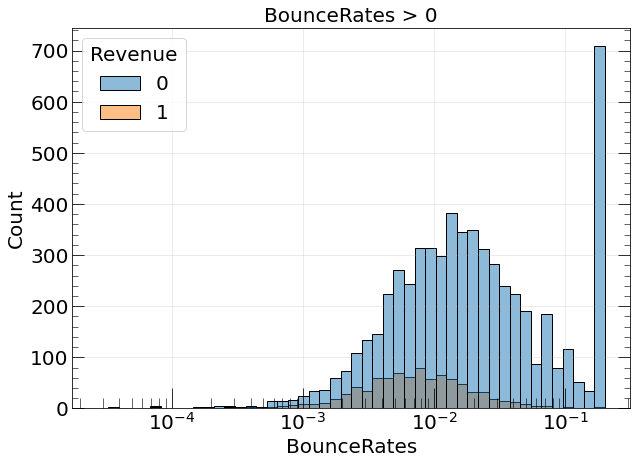

In [56]:
sns.histplot(data[data['BounceRates'] > 0],
             x='BounceRates',
             hue="Revenue",
             multiple="layer",
             log_scale=True
            )
plt.title('BounceRates > 0')
plt.show()

In [57]:
print(
    f"Mean Revenue for objects with BounceRates = 0: {data.loc[data['BounceRates'] == 0, ['Revenue']].mean()[0]}"
)
print(
    f"Mean Revenue for objects with BounceRates > 0: {data.loc[data['BounceRates'] > 0, ['Revenue']].mean()[0]}"
)

Mean Revenue for objects with BounceRates = 0: 0.18774918448713301
Mean Revenue for objects with BounceRates > 0: 0.1280093951849677


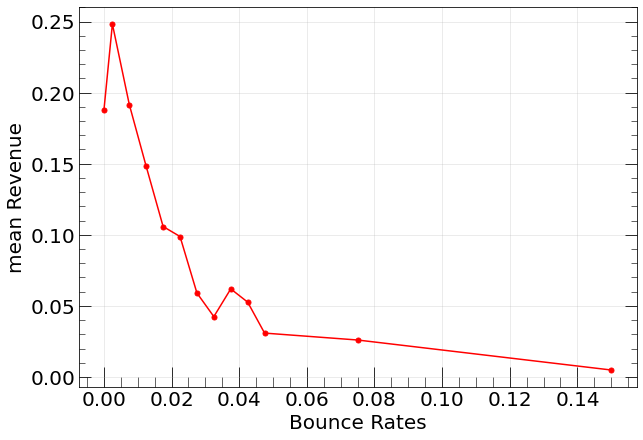

In [58]:
bin_edges = [i*0.005 for i in range(10)] + [i*0.05 for i in range(1, 3)] + [0.2]
bin_centers = [(bin_edges[i]+bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]

bin_values = custom_binning("BounceRates", bin_edges, include_zero=True)
bin_centers = [0] + bin_centers
plt.plot(bin_centers, bin_values, 'o-r')
plt.xlabel('Bounce Rates')
plt.ylabel('mean Revenue')
plt.show()

In [59]:
data[data['BounceRates'] > 0.19]['Revenue'].mean()

0.004285714285714286

In [60]:
data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,0,0
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,0,0
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,0,0
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,0,0
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,1,0


<font size="3">
Lower Bounce Rates correspond to higher chances of Revenue
<font>

### 2.1.5 ExitRates
The value of "Exit Rate" feature for a specific web page is calculated as for all pageviews to the page, the percentage that were the last in the session.

In [61]:
data[(data['ExitRates'] == 0)].shape

(74, 18)

ExitRates -> float64
Mann-Whitney p-value = 6.180024662012867e-174


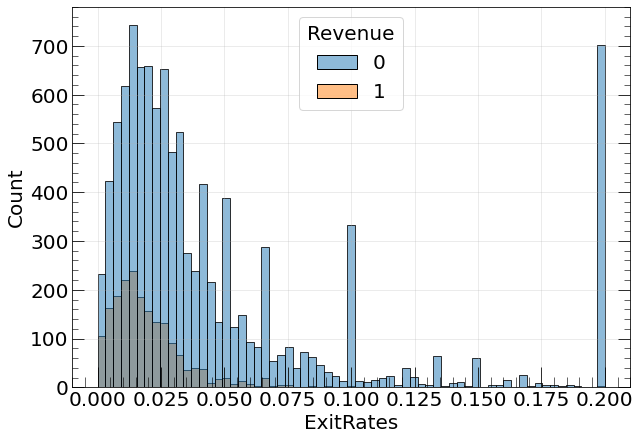

In [62]:
print('ExitRates ->', data['ExitRates'].dtype)
print(f"Mann-Whitney p-value = {mann_whitney('ExitRates')[1]}")
sns.histplot(data,
             x='ExitRates',
             hue="Revenue",
             multiple="layer",
             #log_scale=True
            )
plt.show()

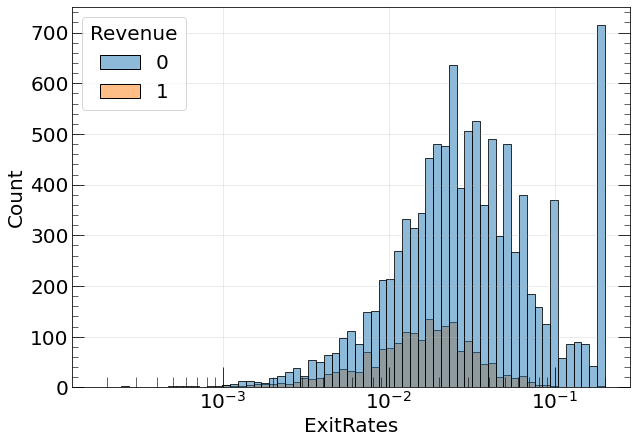

In [63]:
sns.histplot(data[data['ExitRates'] > 0],
             x='ExitRates',
             hue="Revenue",
             multiple="layer",
             log_scale=True
            )
plt.show()

<font size="3">
Lower Exit Rates correspond to higher chances of Revenue
<font>

### 2.1.6 PageValues
The "Page Value" feature represents the average value for a web page that a user visited before completing an e-commerce transaction.

ExitRates -> float64
Mann-Whitney p-value = 0.0


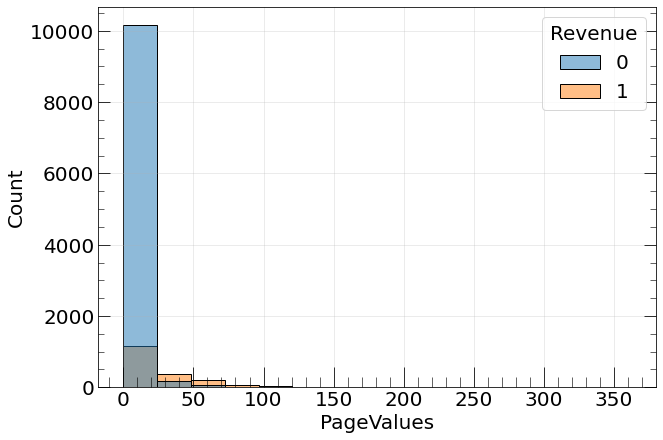

In [64]:
print('ExitRates ->', data['PageValues'].dtype)
print(f"Mann-Whitney p-value = {mann_whitney('PageValues')[1]}")
sns.histplot(data,
             x='PageValues',
             hue="Revenue",
             multiple="layer",
             #log_scale=True
            )
#plt.title('ProductRelated Duration > 0')
plt.show()

ExitRates -> float64
Mann-Whitney p-value = 0.0


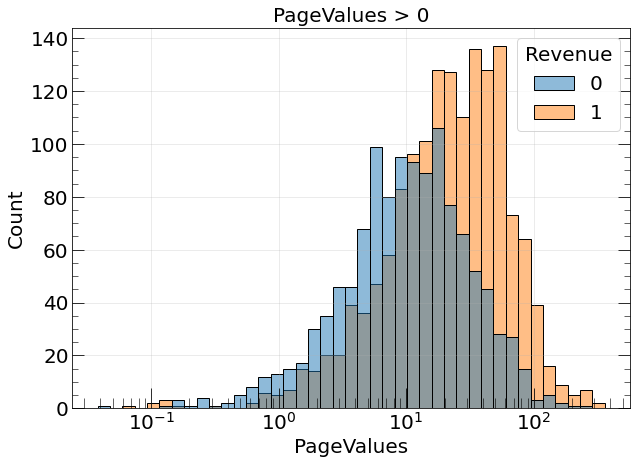

In [65]:
print('ExitRates ->', data['PageValues'].dtype)
print(f"Mann-Whitney p-value = {mann_whitney('PageValues')[1]}")
sns.histplot(data[data['PageValues'] > 0],
             x='PageValues',
             hue="Revenue",
             multiple="layer",
             log_scale=True
            )
plt.title('PageValues > 0')
plt.show()

In [66]:
print(
    f"Mean Revenue for objects with PageValues = 0: {data.loc[data['PageValues'] == 0, ['Revenue']].mean()[0]}"
)
print(
    f"Mean Revenue for objects with PageValues > 0: {data.loc[data['PageValues'] > 0, ['Revenue']].mean()[0]}"
)

Mean Revenue for objects with PageValues = 0: 0.03854166666666667
Mean Revenue for objects with PageValues > 0: 0.5633699633699634


<AxesSubplot:>

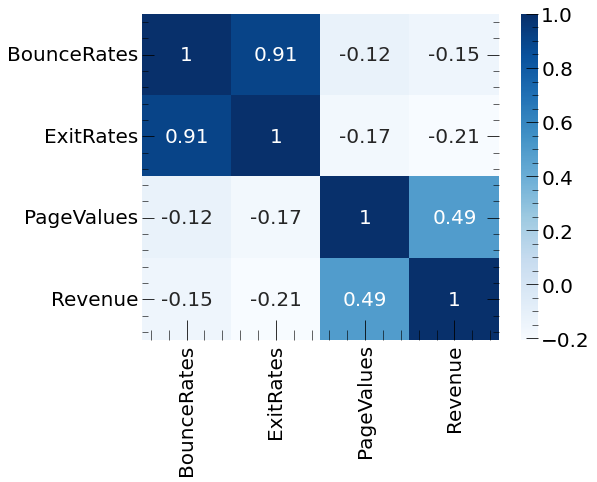

In [67]:
corr = data[['BounceRates', 'ExitRates', 'PageValues', 'Revenue']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, cmap="Blues", annot=True)

<font size="3">
Higher Page Values correspond to higher chances of Revenue
<font>

### 2.1.7 SpecialDay
The "Special Day" feature indicates the closeness of the site visiting time to a specific special day (e.g. Mother’s Day, Valentine's Day) in which the sessions are more likely to be finalized with transaction. The value of this attribute is determined by considering the dynamics of e-commerce such as the duration between the order date and delivery date. For example, for Valentina’s day, this value takes a nonzero value between February 2 and February 12, zero before and after this date unless it is close to another special day, and its maximum value of 1 on February 8.

SpecialDay -> float64
Mann-Whitney p-value = 2.539779818355862e-22


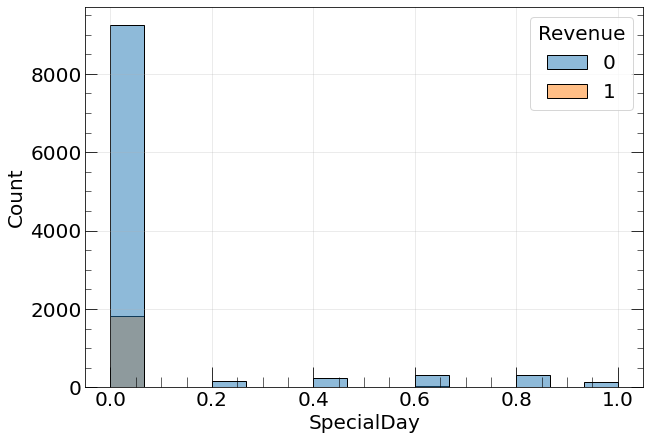

In [68]:
print('SpecialDay ->', data['SpecialDay'].dtype)
print(f"Mann-Whitney p-value = {mann_whitney('SpecialDay')[1]}")
sns.histplot(data,
             x='SpecialDay',
             hue="Revenue",
             multiple="layer",
             #log_scale=True
            )
#plt.title('ProductRelated Duration > 0')
plt.show()

In [69]:
print(
    f"Mean Revenue for objects with SpecialDay = 0: {data.loc[data['SpecialDay'] == 0, ['Revenue']].mean()[0]}"
)
print(
    f"Mean Revenue for objects with SpecialDay > 0: {data.loc[data['SpecialDay'] > 0, ['Revenue']].mean()[0]}"
)

Mean Revenue for objects with SpecialDay = 0: 0.16526762343171766
Mean Revenue for objects with SpecialDay > 0: 0.06155075939248601


In [70]:
data.groupby('SpecialDay').agg(MeanRevenue=('Revenue', 'mean'))

,MeanRevenue
SpecialDay,
0.0,0.165268
0.2,0.078652
0.4,0.053498
0.6,0.082621
0.8,0.033846
1.0,0.064935


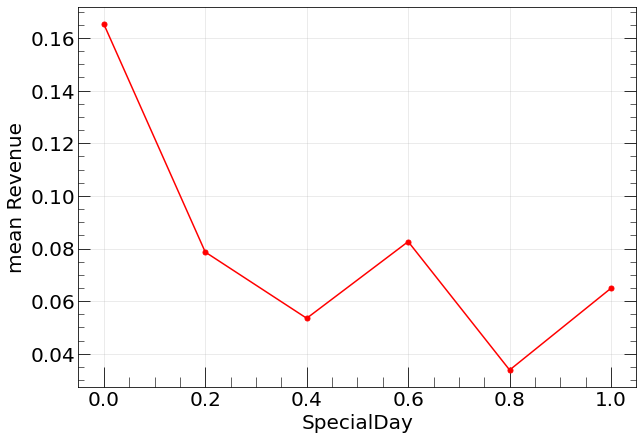

In [71]:
plot_mean_revenue('SpecialDay', 2, -1)

<font size="3">
Special day = 0 corresponds to higher chances of Revenue but it seems that there is not linear trend for [0.2, 1.0].
<font>

### 2.1.8 OperatingSystems

OperatingSystems -> int64
Mann-Whitney p-value = 0.001204234443435673


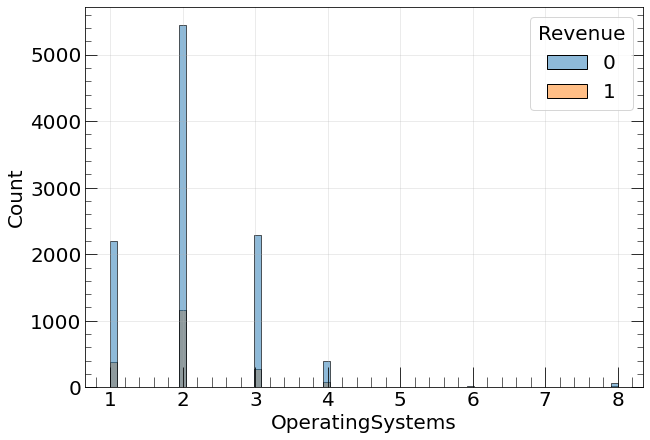

In [72]:
print('OperatingSystems ->', data['OperatingSystems'].dtype)
print(f"Mann-Whitney p-value = {mann_whitney('OperatingSystems')[1]}")
sns.histplot(data,
             x='OperatingSystems',
             hue="Revenue",
             multiple="layer")
plt.show()

In [73]:
data.groupby('OperatingSystems').agg(MeanRevenue=('Revenue', 'mean'))\
    .sort_values(by='MeanRevenue', ascending=False)

,MeanRevenue
OperatingSystems,
8,0.215190
4,0.177824
2,0.174973
5,0.166667
1,0.146615
7,0.142857
6,0.105263
3,0.104892


### 2.1.9 Browser

Browser -> int64
Mann-Whitney p-value = 0.03573101155043872


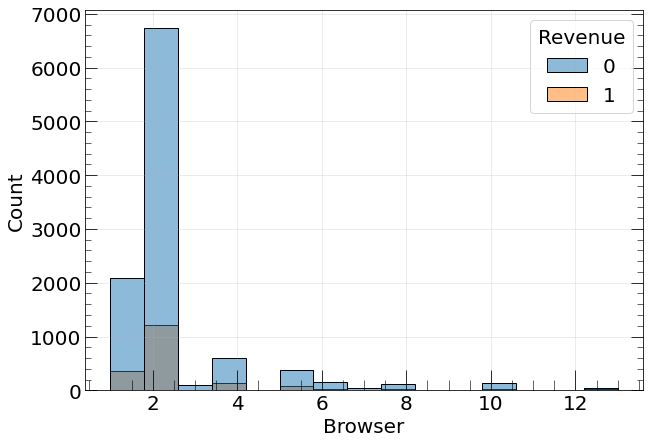

In [74]:
print('Browser ->', data['Browser'].dtype)
print(f"Mann-Whitney p-value = {mann_whitney('Browser')[1]}")
sns.histplot(data,
             x='Browser',
             hue="Revenue",
             multiple="layer")
plt.show()

In [179]:
data.groupby('Browser').agg(MeanRevenue=('Revenue', 'mean'),
                            Count=('Browser', 'count'))\
    .sort_values(by='MeanRevenue', ascending=False)

,MeanRevenue,Count
Browser,,
12,0.300000,10
13,0.262295,61
10,0.196319,163
5,0.184154,467
4,0.176630,736
11,0.166667,6
8,0.155556,135
2,0.153624,7961
1,0.148253,2462


### 2.1.10 Region

Region -> int64
Mann-Whitney p-value = 0.050246039043387626


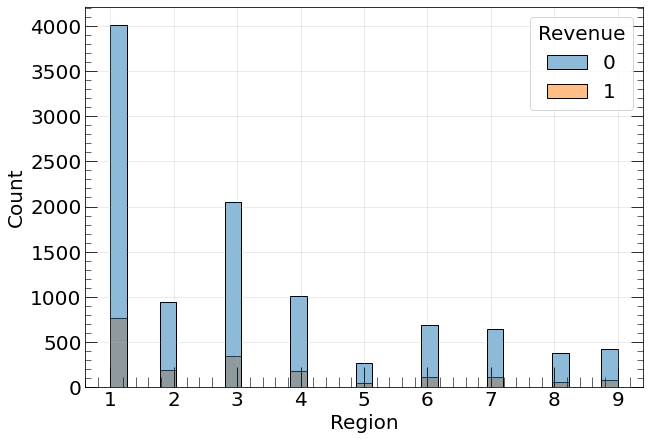

In [76]:
print('Region ->', data['Region'].dtype)
print(f"Mann-Whitney p-value = {mann_whitney('Region')[1]}")
sns.histplot(data,
             x='Region',
             hue="Revenue",
             multiple="layer")
plt.show()

In [77]:
data.groupby('Region').agg(MeanRevenue=('Revenue', 'mean'))

,MeanRevenue
Region,
1,0.161297
2,0.165493
3,0.145235
4,0.148054
5,0.163522
6,0.139130
7,0.156373
8,0.129032
9,0.168297


### 2.1.11 TrafficType

TrafficType -> int64
Mann-Whitney p-value = 0.4474774867863732


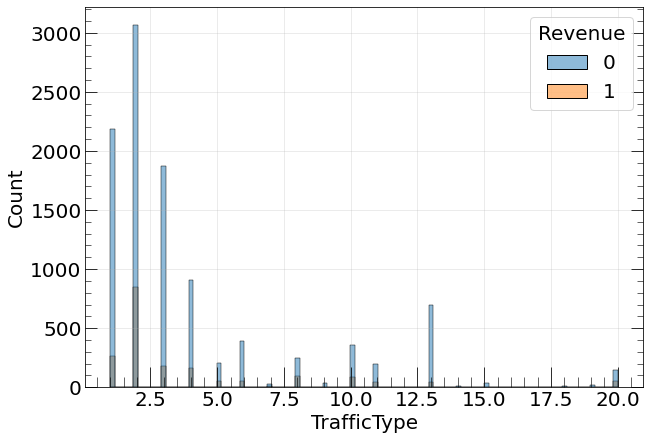

In [78]:
print('TrafficType ->', data['TrafficType'].dtype)
print(f"Mann-Whitney p-value = {mann_whitney('TrafficType')[1]}")
sns.histplot(data,
             x='TrafficType',
             hue="Revenue",
             multiple="layer")
plt.show()

In [79]:
data.groupby('TrafficType').agg(MeanRevenue=('Revenue', 'mean'))\
    .sort_values(by='MeanRevenue', ascending=False)

,MeanRevenue
TrafficType,
16,0.333333
7,0.300000
8,0.276968
20,0.252525
2,0.216458
5,0.215385
10,0.200000
11,0.190283
4,0.154350


### 3.1.12 VisitorType

VisitorType -> object
Mann-Whitney p-value = 2.782286773737866e-31


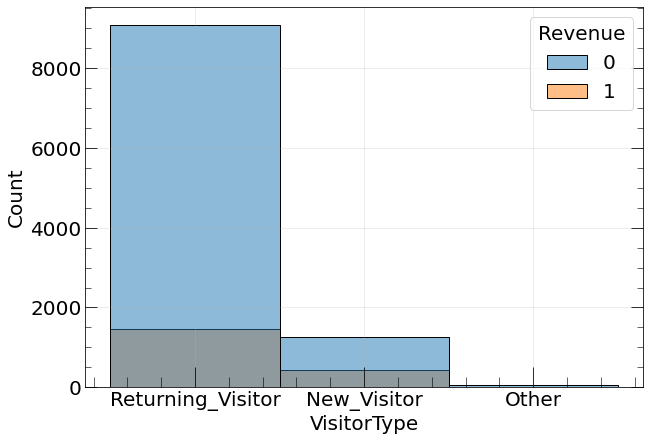

In [80]:
print('VisitorType ->', data['VisitorType'].dtype)
print(f"Mann-Whitney p-value = {mann_whitney('VisitorType')[1]}")
sns.histplot(data,
             x='VisitorType',
             hue="Revenue",
             multiple="layer")
plt.show()

In [81]:
data.groupby('VisitorType').agg(MeanRevenue=('Revenue', 'mean'))\
    .sort_values(by='MeanRevenue', ascending=False)

,MeanRevenue
VisitorType,
New_Visitor,0.249115
Other,0.188235
Returning_Visitor,0.139323


<font size="3">
New visitors buy products more often.
<font>

### 3.1.13 Weekend

Weekend -> int8
Mann-Whitney p-value = 0.0005712959362102452


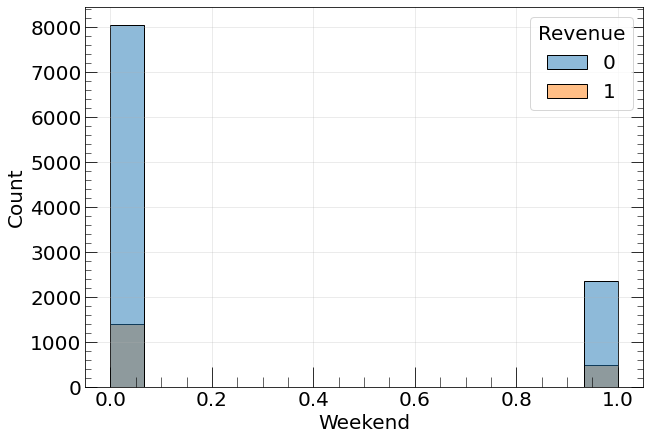

In [82]:
print('Weekend ->', data['Weekend'].dtype)
print(f"Mann-Whitney p-value = {mann_whitney('Weekend')[1]}")
sns.histplot(data,
             x='Weekend',
             hue="Revenue",
             multiple="layer")
plt.show()

In [83]:
data.groupby('Weekend').agg(MeanRevenue=('Revenue', 'mean'))

,MeanRevenue
Weekend,
0,0.148911
1,0.173989


<font size="3">
Slightly better sales on weekend.
<font>

### 3.1.14 Month

In [84]:
data['Month'].nunique()

11

In [85]:
data_orig = pd.read_csv('online_shoppers_intention_original.csv')
data_orig['Month'].nunique()

10

In [86]:
data['Month'] = data['Month'].replace({'aug': 'Aug'})

In [87]:
data['Month'].nunique()

10

Month -> object
Mann-Whitney p-value = 3.630717779810372e-38


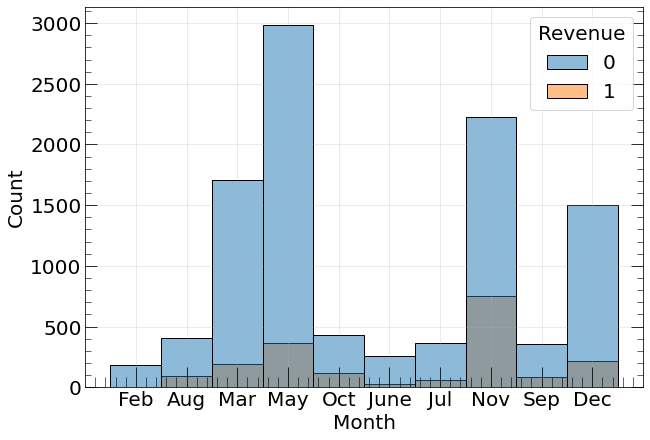

In [88]:
print('Month ->', data['Month'].dtype)
print(f"Mann-Whitney p-value = {mann_whitney('Month')[1]}")
sns.histplot(data,
             x='Month',
             hue="Revenue",
             multiple="layer")
plt.show()

In [89]:
data.groupby('Month').agg(MeanRevenue=('Revenue', 'mean'))\
    .sort_values(by='MeanRevenue', ascending=False)

,MeanRevenue
Month,
Nov,0.252685
Oct,0.211009
Sep,0.192825
Aug,0.183633
Jul,0.149184
Dec,0.124343
May,0.108423
June,0.100694
Mar,0.100158


In [101]:
data_orig.groupby('Month').agg(MeanRevenue=('Revenue', 'mean'),
                               Counts=('Month', 'count'))\
    .sort_values(by='MeanRevenue', ascending=False)

,MeanRevenue,Counts
Month,,
Nov,0.253502,2998
Oct,0.209472,549
Sep,0.191964,448
Aug,0.175520,433
Jul,0.152778,432
Dec,0.125072,1727
May,0.108502,3364
June,0.100694,288
Mar,0.100682,1907


<font size="3">
Better sales at fall, no sales at February
<font>

### 3.1.15 Target: Revenue

<AxesSubplot:xlabel='Revenue', ylabel='Count'>

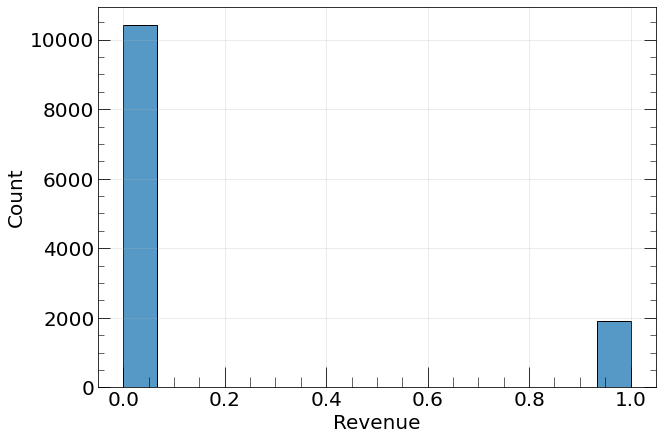

In [91]:
sns.histplot(data['Revenue'])

## Review of feature analysis

<br>

<font size="3">

We can split into pairs the first six features of dataset. These features represent the number of differen types of pages visited by user during the session and time spent on them. Within every pair features are highly correlated. Also as we will see below they have some corelation among all six vectors.

<u>__'Administrative'__ and __'Administrative_Duration'__</u>
    
   For both this features about a half of values equals 0. 
   * The probability for user to make transaction is more then twice higher if any of these two features not 0
   * There are very mild positive linear trend between probability of transaction (mean revenue) and these features
   
   
<u>__'Informational'__ and __'Informational_Duration'__</u>
    
These two features behave very similar to previous pair.


<u>__'ProductRelated'__ and __'ProductRelated_Duration'__</u>
    
Among 3 pairs this is the most correalted wtih target __'Revenue'__ and shows slightly different behaviour with respect to it. Chance to get __'Revenue'__ logarithmically grow with increase of both of these features.
    
<u>__'BounceRates'__</u>
    
"Bounce Rate" feature for a web page refers to the percentage of visitors who enter the site from that page and then leave ("bounce") without triggering any other requests to the analytics server during that session. <br>
As expected the higher values of __'BounceRates'__ correspond to lower chances of getting revenue. The highest value of "Bounce Rate" attributed to 700 objects and they have lamost zero probability of revenue.
    
    
<u>__'ExitRates'__</u>
    
The value of "Exit Rate" feature for a specific web page is calculated as for all pageviews to the page, the percentage that were the last in the session.<br>
These fature has stron correlation __'BounceRates'__ and shows almost the same behaviour. Lower __'ExitRates'__ -- higher chances to get Revenue.
    

<u>__'PageValues'__</u>
    
The "Page Value" feature represents the average value for a web page that a user visited before completing an e-commerce transaction. <br>
This is a strong feature! It has high positive correlation with 'Revenue'.

<u>__'SpecialDay'__</u>
    
Represents the closeness (from the left on time scale) of user session to some holiday from 0 to 1.<br>
Seems like for 'SpecialDay' = 0 the chances of Revenue is higher and more or less constant for others [0.2, 1.0] 

<u>__'Month'__</u>

Average 'Revenue' is higher at autumn (Sep, Oct, Nov) and more generally from July to December. For months from January to June it's lower and almost constant
   
<u>__'OperatingSystems'__</u>
    
Integers from 1 to 8, the most popular is 1, 2, 3. Chances of Revenue are slightly different but it seems that there is no linear trend.
    
<u>__'Browser'__</u>
    
Integers from 1 to 13. No linear trend
    
<u>__'Region'__</u>
    
Integers from 1 to 9. Distribution of transaction probability is almost flat.
    
<u>__'TrafficType'__</u>
    
Integers from 1 to 20. Values of revenue probability are very diverse.

    
<u>__'VisitorType'__</u>
    
Probabilities:
    
New_Visitor $\rightarrow$ 0.249115 <br>
Other $\rightarrow$ 0.188235 <br>
Returning_Visitor $\rightarrow$ 0.139323 <br>
 
    
<u>__'Weekend'__</u>
    
1 or 0, Revenue probbility is slightly higher on weekend.

    
<font>

## 3.2 Correlation

### 3.2.1 Numeric-numeric

### Pearson

In [92]:
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

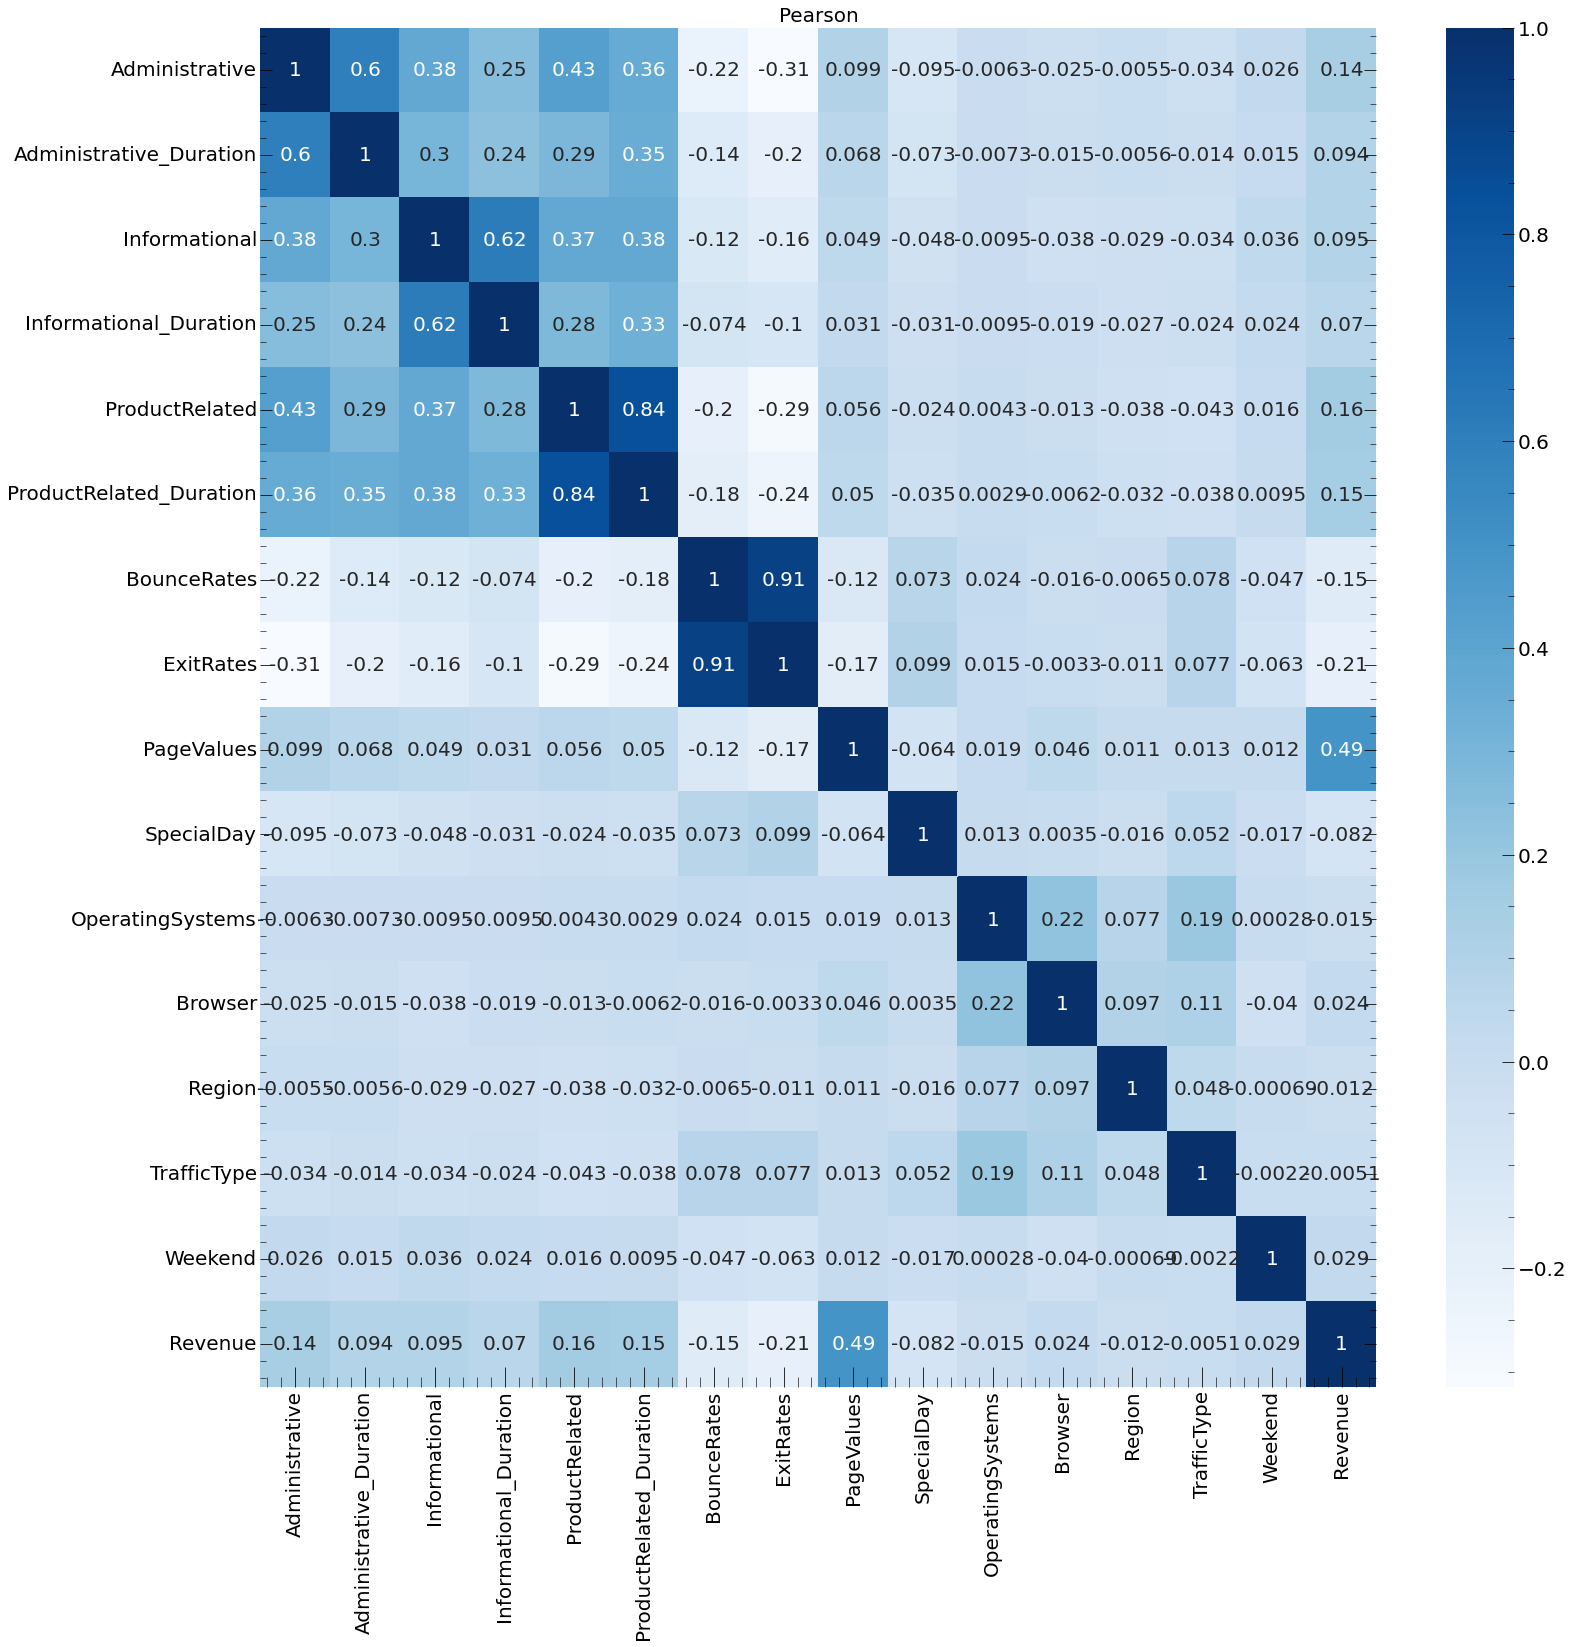

In [93]:
plt.figure(figsize=(25, 25))
sns.heatmap(corr, cmap="Blues", annot=True)
plt.title("Pearson")
plt.show()

### Spearman

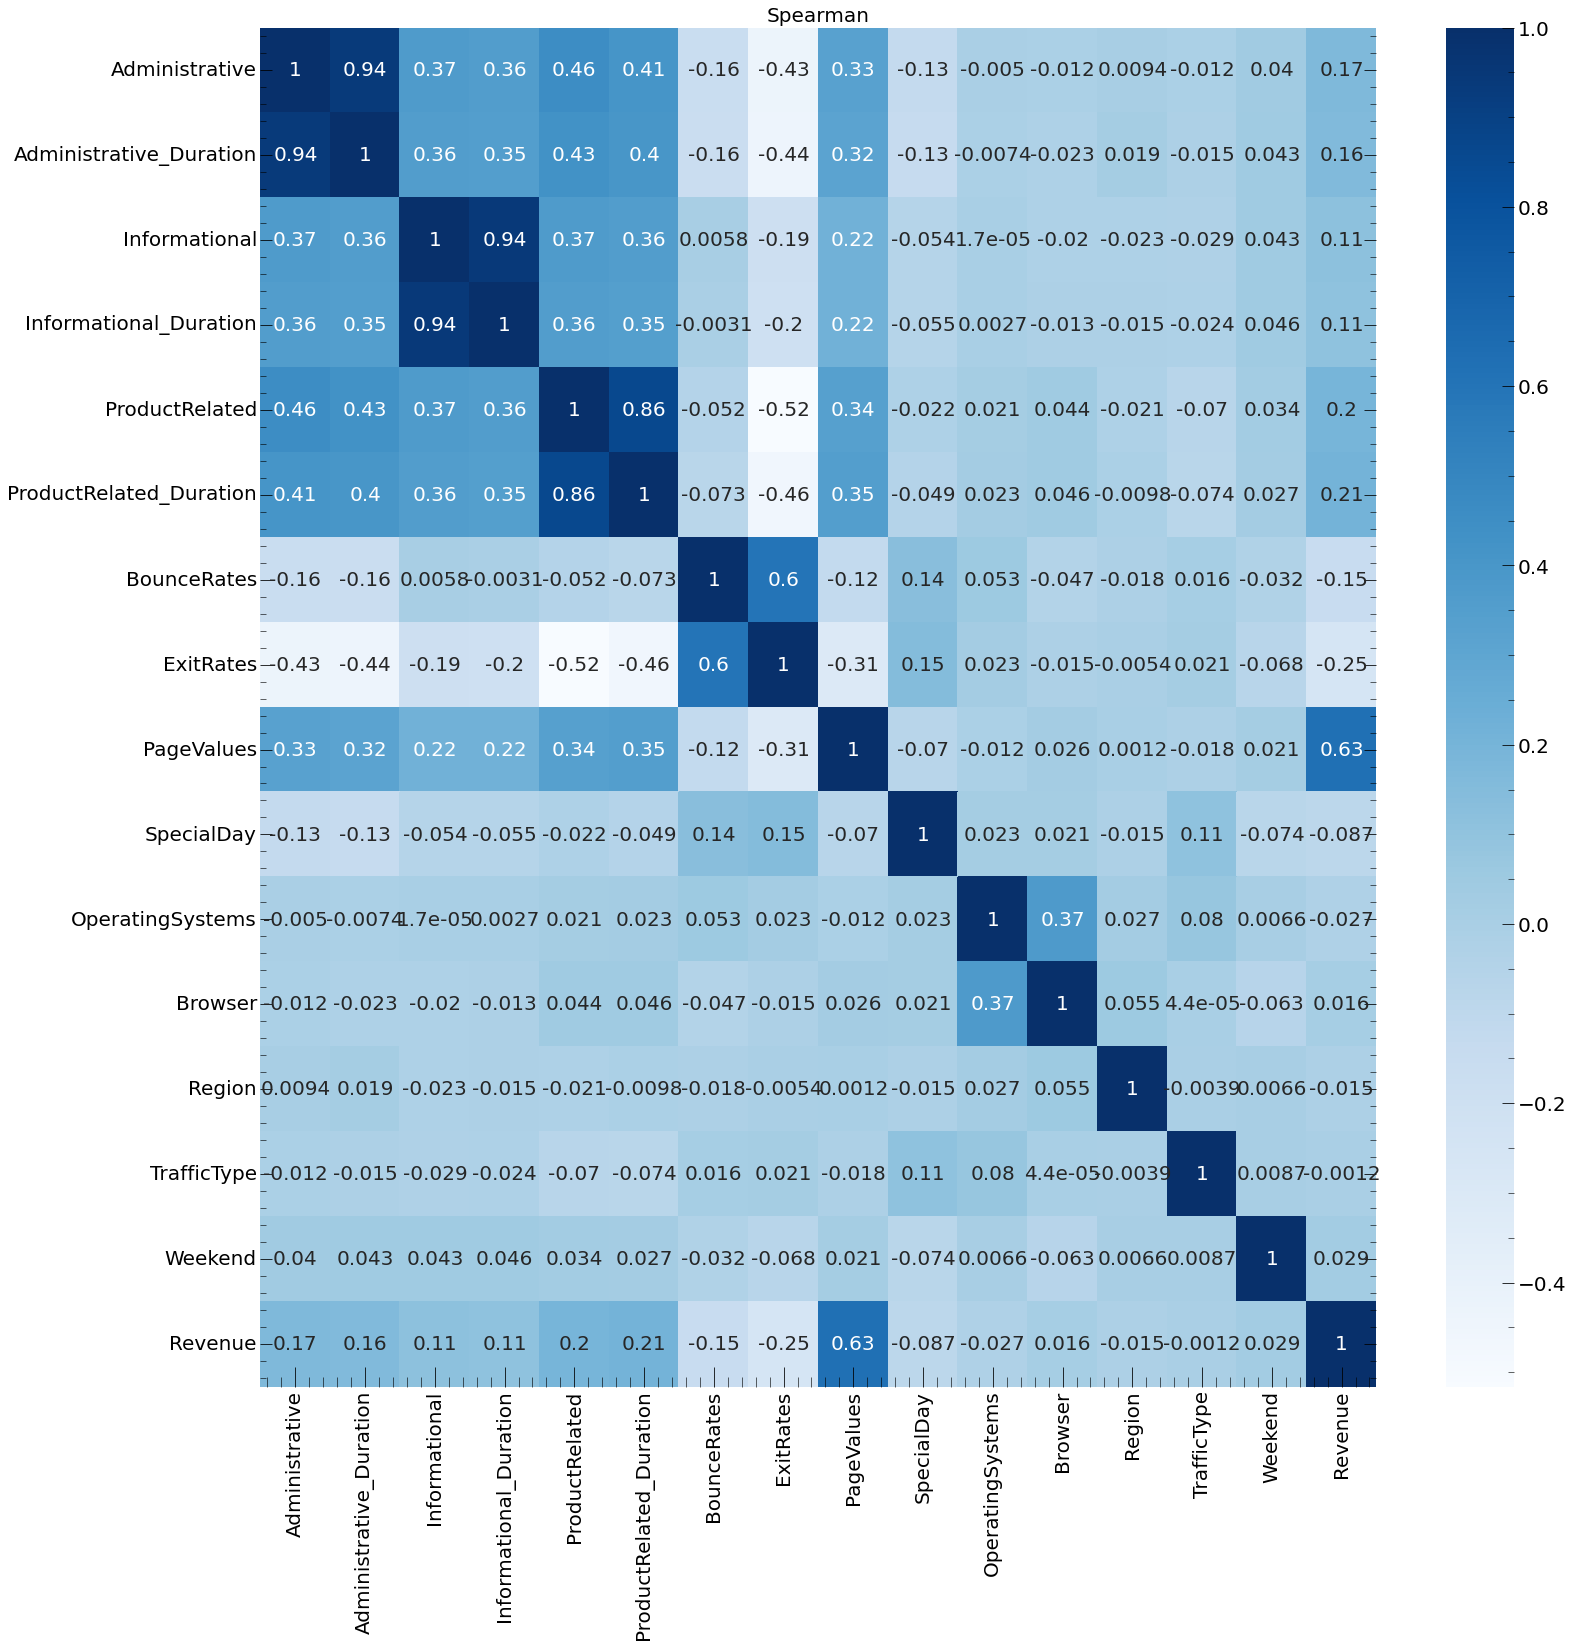

In [94]:
corr = data.corr(method='spearman')

plt.figure(figsize=(25, 25))
sns.heatmap(corr, cmap="Blues", annot=True)
plt.title("Spearman")
plt.show()

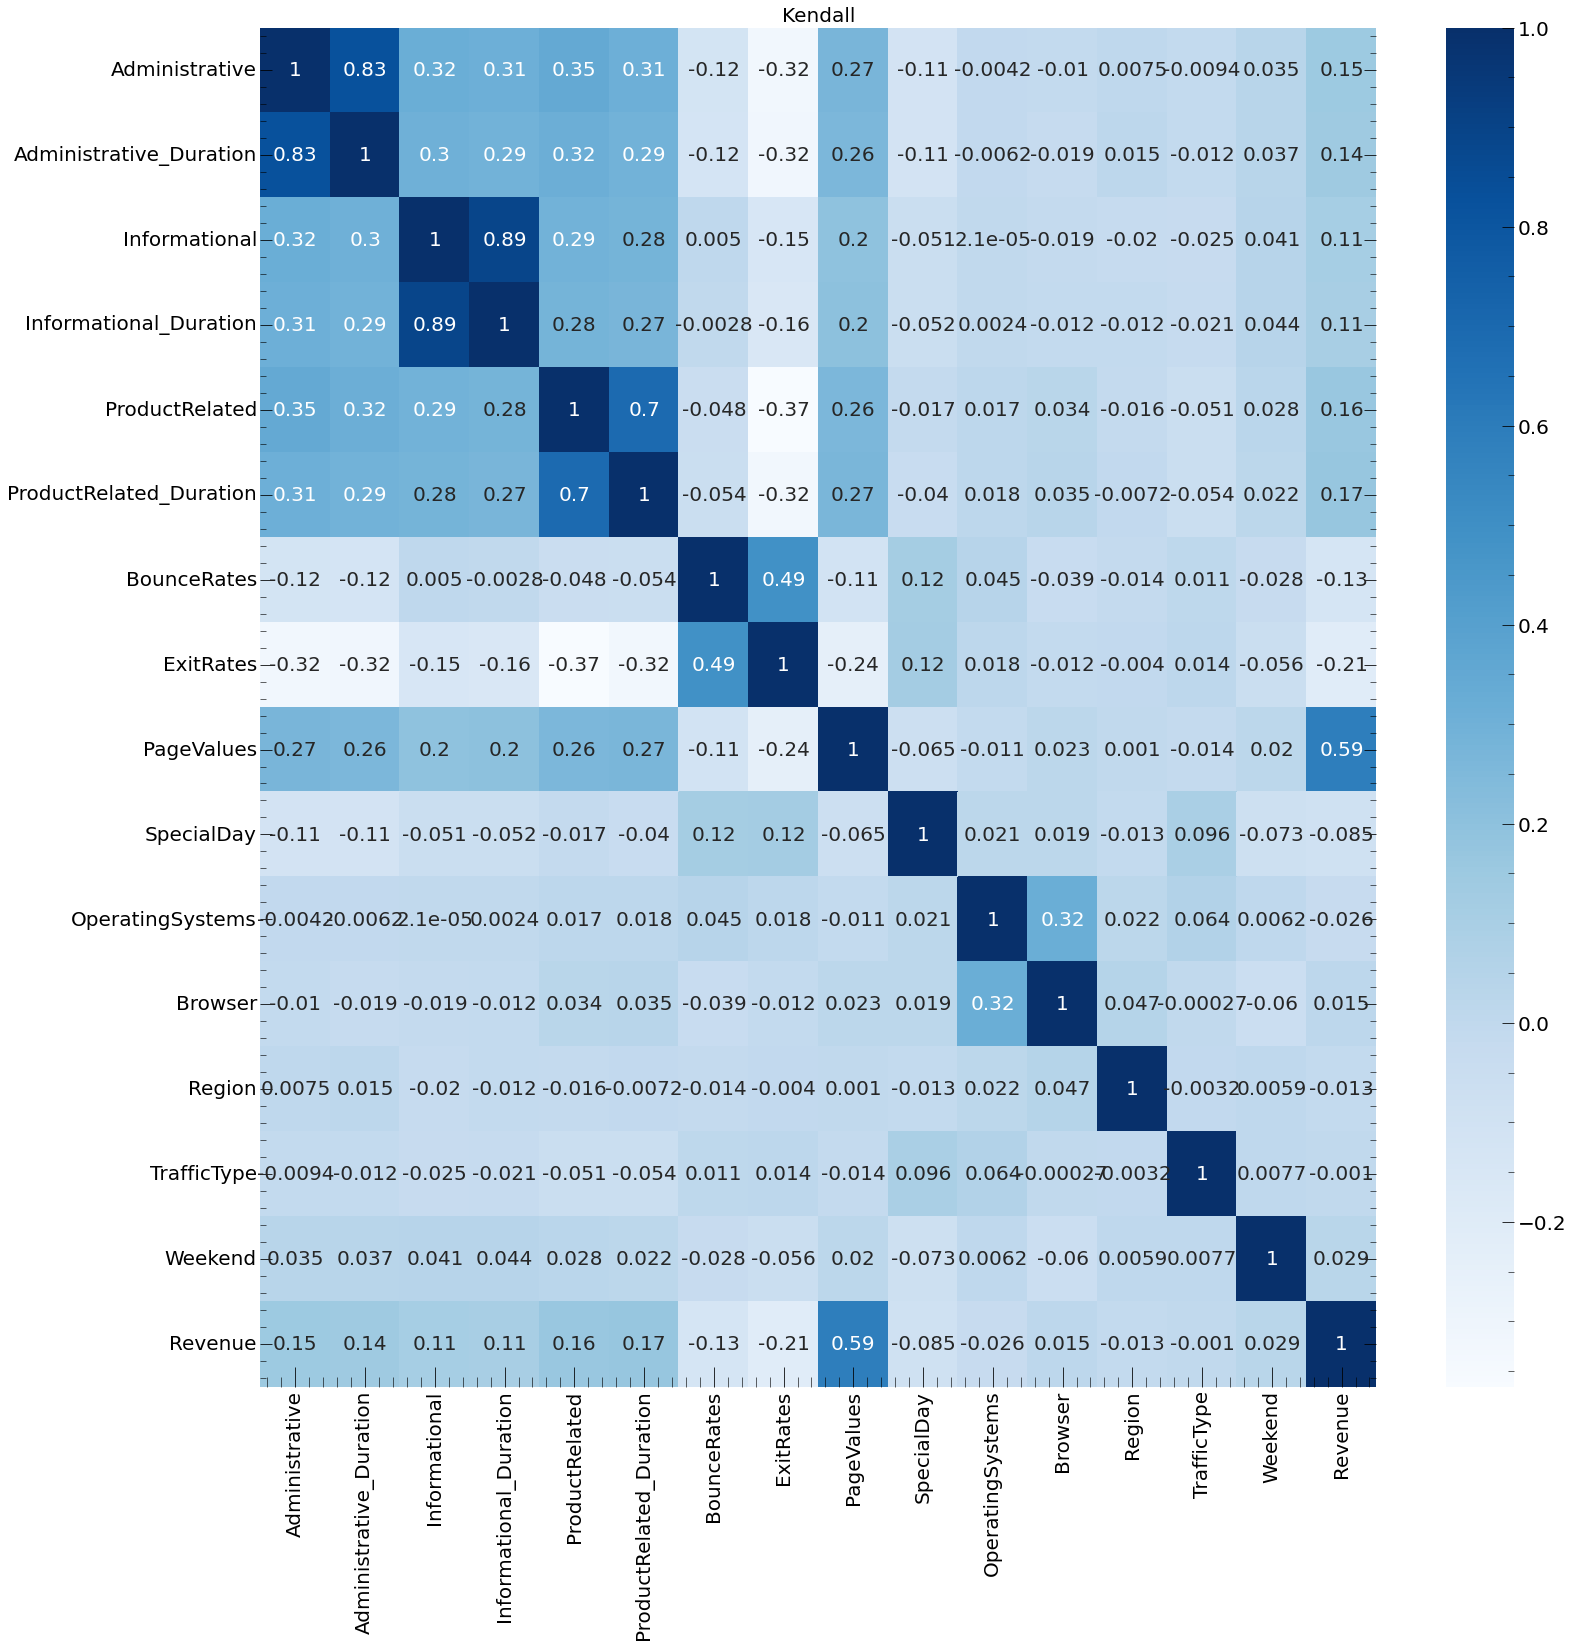

In [95]:
corr = data.corr(method='kendall')

plt.figure(figsize=(25, 25))
sns.heatmap(corr, cmap="Blues", annot=True)
plt.title("Kendall")
plt.show()

### 3.2.2 Categrical-catrgorical

### Cramer

In [96]:
import association_metrics as am

data_cat = data.apply(lambda x: x.astype("category") if x.dtype == "object" else x)
cramersv = am.CramersV(data_cat)

cramersv.fit()

,Month,VisitorType
Month,1.000000,0.140318
VisitorType,0.140318,1.000000


Low correlation between Month and VisitorType

### 3.2.3 Categorical-numerical

In [97]:
cat_cols = data.columns[data.dtypes == object]
cat_cols

Index(['Month', 'VisitorType'], dtype='object')

### ANOVA

In [98]:
def one_way_anova(feature_cat, feature_num):
    print('-'*40)
    print(f'Feature: {feature_cat}')
    feature_unique = data[feature_cat].unique()
    feature_unique.sort()
    print(', '.join(map(str, list(feature_unique.tolist()))))
    # Both methods are ok
    samples = [list(frame) for group, frame in data.groupby(feature_cat)[feature_num]]
    F, p = stats.f_oneway(*samples)
    print(f'F = {F}')
    print(f'p = {p}')
    if (p < 0.05):
        print('Reject H0')
    else:
        print('Accept H0')
    print('-'*40)
    
for col in cat_cols:
    one_way_anova(col, 'Revenue')

----------------------------------------
Feature: Month
Aug, Dec, Feb, Jul, June, Mar, May, Nov, Oct, Sep
F = 43.934872806075106
p = 2.610746439809e-78
Reject H0
----------------------------------------
----------------------------------------
Feature: VisitorType
New_Visitor, Other, Returning_Visitor
F = 68.35936429519808
p = 2.9876747650451863e-30
Reject H0
----------------------------------------


### Inference

<br>

<font size="3">
    
As we see from ANOVA test for two categiracal fatures vs target ('Revenue') the null hypothesis H0 that there is no difference between mean values in group can be rejected. However distribution of 'Revenue' is not normall and we shouldn't rely too much on these results.
    
<font>

In [99]:
data.corr()['Revenue'].apply(lambda x: np.abs(x)).sort_values(ascending=False)

Revenue                    1.000000
PageValues                 0.492569
ExitRates                  0.205753
ProductRelated             0.158538
BounceRates                0.150673
ProductRelated_Duration    0.148449
Administrative             0.138917
Informational              0.095200
Administrative_Duration    0.093587
SpecialDay                 0.082305
Informational_Duration     0.069594
Weekend                    0.029295
Browser                    0.023984
OperatingSystems           0.014668
Region                     0.011595
TrafficType                0.005113
Name: Revenue, dtype: float64

### Review of correlation analysis

<br>

<font size="3">

Features that have the highest correlation with target, i.e. |pearson| >= 0.10 or ANOVA:
* 'PageValues'
* 'ExitRates'
* 'ProductRelated'
* 'BounceRates'
* 'ProductRelated_Duration'
* 'Administrative'
* 'Month'
* 'VisitorType'
    
There are also features correlated with each other. If we are planning to apply linear model we should definitely drop some of the following features:
* One from each pair of 'X' and 'X_Duration'
* One from 'BounceRates' and 'ExitRates'
    
<font>

# Feature engineering

### Month

In [107]:
data['Month'].value_counts()

May     3348
Nov     2980
Mar     1897
Dec     1713
Oct      545
Aug      501
Sep      446
Jul      429
June     288
Feb      183
Name: Month, dtype: int64

In [112]:
def define_season(month: str) -> str:
    if month in ['June', 'Jul', 'Aug']:
        return 'Summer'
    elif month in ['Mar', 'May']:
        return 'Spring'
    elif month in ['Sep', 'Oct', 'Nov']:
        return 'Fall'
    else:
        return 'Winter'
    
data['Season'] = data['Month'].apply(lambda x: define_season(x))

In [113]:
data.groupby('Season').agg(MeanRevenue=('Revenue', 'mean'))

,MeanRevenue
Season,
Fall,0.240242
Spring,0.105434
Summer,0.151888
Winter,0.113924


In [114]:
data.drop(['Season'], axis=1, inplace=True)
data['Season_Summer'] = data['Month'].apply(lambda x: int(x in ['June', 'Jul', 'Aug']))
data['Season_Spring'] = data['Month'].apply(lambda x: int(x in ['Mar', 'May']))
data['Season_Fall'] = data['Month'].apply(lambda x: int(x in ['Sep', 'Oct', 'Nov']))

## Categorical features encoding

In [118]:
from sklearn.preprocessing import OneHotEncoder

In [123]:
data_cat = data[['Month', 'VisitorType']]
data_cat

,Month,VisitorType
0,Feb,Returning_Visitor
1,Feb,Returning_Visitor
2,Feb,Returning_Visitor
3,Feb,Returning_Visitor
4,Feb,Returning_Visitor
...,...,...
12325,Dec,Returning_Visitor
12326,Nov,Returning_Visitor
12327,Nov,Returning_Visitor
12328,Nov,Returning_Visitor


In [129]:
cat_encoder = OneHotEncoder(drop='first')
data_cat_encoded = cat_encoder.fit_transform(data_cat)
data_cat_encoded

<12330x11 sparse matrix of type '<class 'numpy.float64'>'
	with 22465 stored elements in Compressed Sparse Row format>

In [141]:
cat_encoder.categories_

[array(['Aug', 'Dec', 'Feb', 'Jul', 'June', 'Mar', 'May', 'Nov', 'Oct',
        'Sep'], dtype=object),
 array(['New_Visitor', 'Other', 'Returning_Visitor'], dtype=object)]

In [133]:
data_cat_encoded.toarray().shape

(12330, 11)

In [144]:
data_new = pd.get_dummies(data, drop_first=True)

In [147]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Administrative                 12330 non-null  int64  
 1   Administrative_Duration        12330 non-null  float64
 2   Informational                  12330 non-null  int64  
 3   Informational_Duration         12330 non-null  float64
 4   ProductRelated                 12330 non-null  int64  
 5   ProductRelated_Duration        12330 non-null  float64
 6   BounceRates                    12330 non-null  float64
 7   ExitRates                      12330 non-null  float64
 8   PageValues                     12330 non-null  float64
 9   SpecialDay                     12330 non-null  float64
 10  OperatingSystems               12330 non-null  int64  
 11  Browser                        12330 non-null  int64  
 12  Region                         12330 non-null 

# Feature selection

<AxesSubplot:>

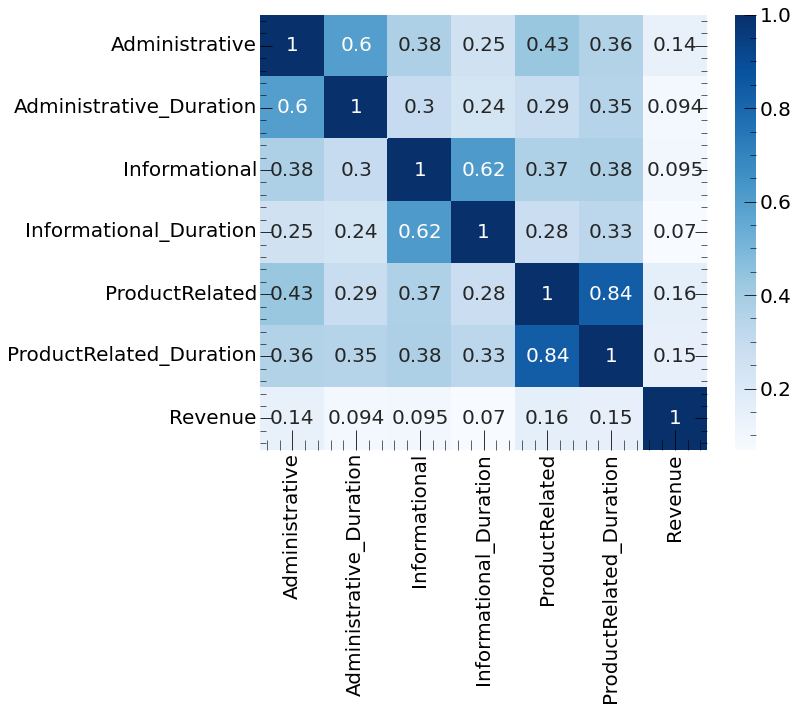

In [149]:
corr = data_new[[
    "Administrative", "Administrative_Duration", "Informational",
    "Informational_Duration", "ProductRelated", "ProductRelated_Duration",
    "Revenue"
]].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="Blues", annot=True)

# CatBoost model

In [152]:
from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import optuna

In [153]:
data_catboost = data.drop(['Season_Summer', 'Season_Spring', 'Season_Fall'], axis=1)

In [154]:
X = data_catboost.drop('Revenue', axis=1)
y = data_catboost['Revenue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [155]:
categorical_features_indices = np.where(X.dtypes == object)[0]
categorical_features_indices

array([10, 15])

In [158]:
model = CatBoostClassifier()

model.fit(X_train, y_train,
         cat_features=categorical_features_indices,
         logging_level='Silent')

pred = model.predict(X_test)

print('roc_auc_score           = ', roc_auc_score(y_test, pred))
print('f1_score                = ', f1_score(y_test, pred))

roc_auc_score           =  0.7608272506082725
f1_score                =  0.6372413793103449


In [159]:
pd.DataFrame({'Feature': model.feature_names_, "Importance": model.feature_importances_})\
    .sort_values(by='Importance', ascending=False)

,Feature,Importance
10,Month,27.172674
8,PageValues,23.066935
7,ExitRates,5.790398
5,ProductRelated_Duration,5.752130
4,ProductRelated,5.614824
6,BounceRates,4.500291
1,Administrative_Duration,4.390702
0,Administrative,4.286184
15,VisitorType,4.081817
14,TrafficType,3.635993


In [178]:
from sklearn.inspection import permutation_importance

model_permutation_importance = permutation_importance(model,
                                                      X_test,
                                                      y_test,
                                                      scoring='roc_auc',
                                                      n_repeats=20,
                                                      random_state=0,
                                                      n_jobs=-1)

pd.DataFrame({'Feature': data_catboost.columns.drop('Revenue'), 
              'Permutation importance mean': model_permutation_importance.importances_mean,
              'Permutation importance std': model_permutation_importance.importances_std}).\
    sort_values(by="Permutation importance mean", ascending=False)

,Feature,Permutation importance mean,Permutation importance std
8,PageValues,0.302846,0.011245
10,Month,0.050175,0.004505
5,ProductRelated_Duration,0.004559,0.001074
1,Administrative_Duration,0.003859,0.000958
4,ProductRelated,0.003424,0.001293
7,ExitRates,0.002618,0.001439
0,Administrative,0.002110,0.000767
6,BounceRates,0.001707,0.000654
15,VisitorType,0.001700,0.000730
9,SpecialDay,0.000615,0.000710


## Drop some features
### Step 1: Features with flat distributions

In [183]:
features_to_drop = ['Region', 'Browser', 'OperatingSystems']

data_catboost = data_catboost.drop(features_to_drop, axis=1)

X = data_catboost.drop('Revenue', axis=1)
y = data_catboost['Revenue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
categorical_features_indices = np.where(X.dtypes == object)[0]

In [184]:
# train model again

model.fit(X_train, y_train,
         cat_features=categorical_features_indices,
         logging_level='Silent')

pred = model.predict(X_test)

print('roc_auc_score           = ', roc_auc_score(y_test, pred))
print('f1_score                = ', f1_score(y_test, pred))

roc_auc_score           =  0.7637469586374696
f1_score                =  0.6402188782489739


In [190]:
model_permutation_importance = permutation_importance(model,
                                                      X_test,
                                                      y_test,
                                                      scoring='roc_auc',
                                                      n_repeats=50,
                                                      random_state=0,
                                                      n_jobs=-1)

df_importance = pd.DataFrame({'Feature': model.feature_names_,
                              'CatBoost Importance': model.feature_importances_,
                              'Permutation Importance': model_permutation_importance.importances_mean,
                              'Permutation Importance std': model_permutation_importance.importances_std})

df_importance.sort_values(by='CatBoost Importance', ascending=False)

,Feature,CatBoost Importance,Permutation Importance,Permutation Importance std
10,Month,30.328691,0.049802,0.005025
8,PageValues,24.065203,0.304415,0.008932
5,ProductRelated_Duration,6.587847,0.002512,0.001281
7,ExitRates,6.274301,0.002651,0.001627
4,ProductRelated,6.216563,0.004044,0.001311
1,Administrative_Duration,5.488062,0.004151,0.001090
0,Administrative,4.140932,0.001461,0.001113
6,BounceRates,3.865517,0.001206,0.000884
11,TrafficType,3.826304,0.000019,0.000734
12,VisitorType,3.027438,0.001460,0.000690


### Step 2: Features with low importance pt.1

In [191]:
features_to_drop = ['Weekend', 'Informational', 'SpecialDay']

data_catboost = data_catboost.drop(features_to_drop, axis=1)

X = data_catboost.drop('Revenue', axis=1)
y = data_catboost['Revenue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
categorical_features_indices = np.where(X.dtypes == object)[0]

# train model again

model.fit(X_train, y_train,
         cat_features=categorical_features_indices,
         logging_level='Silent')

pred = model.predict(X_test)

print('roc_auc_score           = ', roc_auc_score(y_test, pred))
print('f1_score                = ', f1_score(y_test, pred))

roc_auc_score           =  0.7720194647201947
f1_score                =  0.654843110504775


In [192]:
model_permutation_importance = permutation_importance(model,
                                                      X_test,
                                                      y_test,
                                                      scoring='roc_auc',
                                                      n_repeats=50,
                                                      random_state=0,
                                                      n_jobs=-1)

df_importance = pd.DataFrame({'Feature': model.feature_names_,
                              'CatBoost Importance': model.feature_importances_,
                              'Permutation Importance': model_permutation_importance.importances_mean,
                              'Permutation Importance std': model_permutation_importance.importances_std})

df_importance.sort_values(by='CatBoost Importance', ascending=False)

,Feature,CatBoost Importance,Permutation Importance,Permutation Importance std
8,Month,30.417037,0.051733,0.005278
7,PageValues,23.743772,0.300657,0.008701
6,ExitRates,6.872837,0.004790,0.001814
3,ProductRelated,6.626392,0.004259,0.001410
4,ProductRelated_Duration,6.494768,0.002787,0.001054
1,Administrative_Duration,6.261664,0.005295,0.001211
5,BounceRates,4.426055,0.001036,0.000733
9,TrafficType,4.315153,0.000198,0.000737
10,VisitorType,3.991939,0.001344,0.000692
0,Administrative,3.831909,0.001674,0.001120


### Step 3: Features with low importance and high multicolliniarity

<AxesSubplot:>

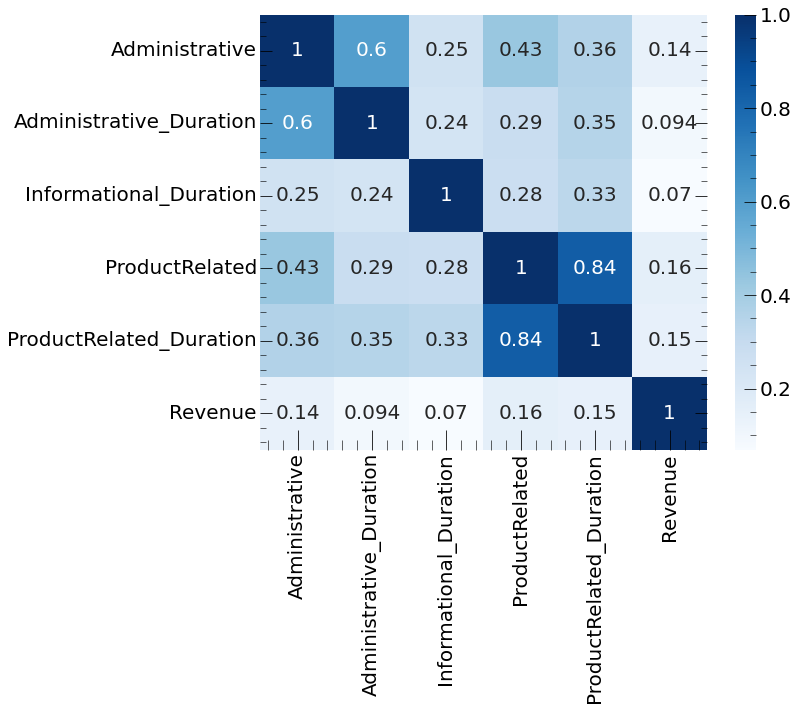

In [193]:
corr = data_catboost[[
    "Administrative", "Administrative_Duration",
    "Informational_Duration", "ProductRelated", "ProductRelated_Duration",
    "Revenue"
]].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="Blues", annot=True)

In [194]:
data_catboost.columns

Index(['Administrative', 'Administrative_Duration', 'Informational_Duration',
       'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates',
       'PageValues', 'Month', 'TrafficType', 'VisitorType', 'Revenue'],
      dtype='object')

<AxesSubplot:>

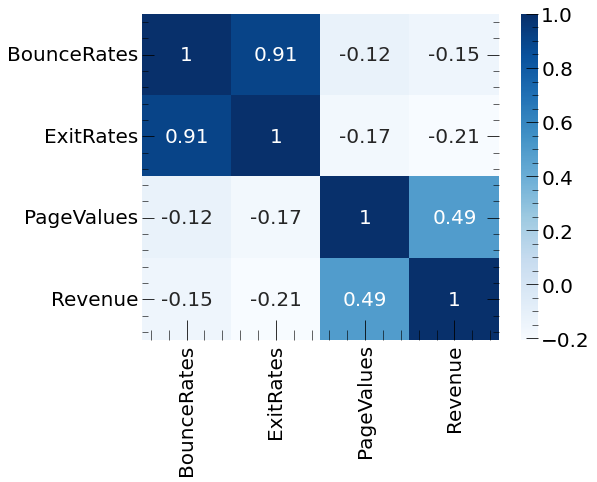

In [195]:
corr = data_catboost[[
    'BounceRates', 'ExitRates', 'PageValues', "Revenue"
]].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, cmap="Blues", annot=True)

In [196]:
features_to_drop = ['Administrative', 'ProductRelated_Duration', 'BounceRates']

data_catboost = data_catboost.drop(features_to_drop, axis=1)

X = data_catboost.drop('Revenue', axis=1)
y = data_catboost['Revenue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
categorical_features_indices = np.where(X.dtypes == object)[0]

# train model again

model.fit(X_train, y_train,
         cat_features=categorical_features_indices,
         logging_level='Silent')

pred = model.predict(X_test)

print('roc_auc_score           = ', roc_auc_score(y_test, pred))
print('f1_score                = ', f1_score(y_test, pred))

roc_auc_score           =  0.7632603406326033
f1_score                =  0.640990371389271


In [197]:
model_permutation_importance = permutation_importance(model,
                                                      X_test,
                                                      y_test,
                                                      scoring='roc_auc',
                                                      n_repeats=50,
                                                      random_state=0,
                                                      n_jobs=-1)

df_importance = pd.DataFrame({'Feature': model.feature_names_,
                              'CatBoost Importance': model.feature_importances_,
                              'Permutation Importance': model_permutation_importance.importances_mean,
                              'Permutation Importance std': model_permutation_importance.importances_std})

df_importance.sort_values(by='CatBoost Importance', ascending=False)

,Feature,CatBoost Importance,Permutation Importance,Permutation Importance std
5,Month,40.213442,0.052713,0.005321
4,PageValues,22.648970,0.309648,0.008854
2,ProductRelated,9.974659,0.012738,0.002188
3,ExitRates,8.554458,0.010778,0.001896
0,Administrative_Duration,7.076151,0.010753,0.001681
6,TrafficType,4.604048,0.000538,0.000870
7,VisitorType,3.848461,0.002026,0.000836
1,Informational_Duration,3.079812,-0.000942,0.000728


## CatBoost hyperparameters tuning

In [207]:
X_train_tuning, X_val, y_train_tuning, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [208]:
def objective(trial):

    param = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, step=0.001)
        #"min_child_samples": trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
    }

    estimator = CatBoostClassifier(**param,
                                  cat_features=categorical_features_indices,
                                  custom_metric='AUC',
                                  verbose=False)

    estimator.fit(X_train_tuning, y_train_tuning)
    pred = estimator.predict(X_val)

    return roc_auc_score(y_val, pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, n_jobs=-1)
print(study.best_trial)

[I 2023-07-24 00:03:40,558] A new study created in memory with name: no-name-58d6fb10-6dda-4ee0-8e6f-078ed5aae589
[I 2023-07-24 00:03:44,482] Trial 0 finished with value: 0.7511510201507364 and parameters: {'n_estimators': 306, 'max_depth': 2, 'learning_rate': 0.025}. Best is trial 0 with value: 0.7511510201507364.
[I 2023-07-24 00:03:47,513] Trial 4 finished with value: 0.7601266122165811 and parameters: {'n_estimators': 129, 'max_depth': 8, 'learning_rate': 0.012}. Best is trial 4 with value: 0.7601266122165811.
[I 2023-07-24 00:03:47,759] Trial 1 finished with value: 0.7517560940998391 and parameters: {'n_estimators': 608, 'max_depth': 2, 'learning_rate': 0.051000000000000004}. Best is trial 4 with value: 0.7601266122165811.
[I 2023-07-24 00:03:52,884] Trial 2 finished with value: 0.7593806171360096 and parameters: {'n_estimators': 843, 'max_depth': 3, 'learning_rate': 0.061}. Best is trial 4 with value: 0.7601266122165811.
[I 2023-07-24 00:03:53,464] Trial 6 finished with value: 0.

FrozenTrial(number=5, state=TrialState.COMPLETE, values=[0.7677452224780044], datetime_start=datetime.datetime(2023, 7, 24, 0, 3, 47, 523478), datetime_complete=datetime.datetime(2023, 7, 24, 0, 3, 58, 199585), params={'n_estimators': 471, 'max_depth': 7, 'learning_rate': 0.001}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=10, step=1), 'max_depth': IntDistribution(high=10, log=False, low=1, step=1), 'learning_rate': FloatDistribution(high=0.1, log=False, low=0.001, step=0.001)}, trial_id=5, value=None)


In [209]:
print(study.best_trial.params)

{'n_estimators': 471, 'max_depth': 7, 'learning_rate': 0.001}


In [210]:
model = CatBoostClassifier(**study.best_params,
                           cat_features=categorical_features_indices,
                           logging_level='Silent')

model.fit(X_train, y_train)
pred = model.predict(X_test)

print('roc_auc_score           = ', roc_auc_score(y_test, pred))
print('f1_score                = ', f1_score(y_test, pred))

roc_auc_score           =  0.7742092457420926
f1_score                =  0.6498673740053051


In [211]:
model_permutation_importance = permutation_importance(model,
                                                      X_test,
                                                      y_test,
                                                      scoring='roc_auc',
                                                      n_repeats=50,
                                                      random_state=0,
                                                      n_jobs=-1)

df_importance = pd.DataFrame({'Feature': model.feature_names_,
                              'CatBoost Importance': model.feature_importances_,
                              'Permutation Importance': model_permutation_importance.importances_mean,
                              'Permutation Importance std': model_permutation_importance.importances_std})

df_importance.sort_values(by='CatBoost Importance', ascending=False)

,Feature,CatBoost Importance,Permutation Importance,Permutation Importance std
4,PageValues,57.396852,0.293643,0.008184
5,Month,24.723145,0.037205,0.003897
7,VisitorType,4.646462,0.006866,0.001375
0,Administrative_Duration,4.396328,0.004081,0.001281
2,ProductRelated,3.882156,0.005449,0.001109
3,ExitRates,3.247741,0.001495,0.000595
1,Informational_Duration,0.929150,-0.000020,0.000458
6,TrafficType,0.778166,0.000196,0.000128
